<a href="https://colab.research.google.com/github/gerritgr/Alia/blob/main/train_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AliaMolecule Inference

#### Project Name

In [ ]:
#!pip install wandb --force-reinstall

In [ ]:
PROJECT_NAME = "AliaMoleculeDeskBaseline"
PATH_PATTERN = "aliamolEllisDisc" #aliamol2 is trained on denoised image

#### Setup

In [ ]:
# Load drive

import os
USE_COLAB = False
try:
  from google.colab import drive
  USE_COLAB = True
except:
  pass

try:
  import wandb # need to do this before chaning cwd
except:
  os.system("pip install wandb")


if USE_COLAB:
  if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
  dir_path = f'/content/drive/MyDrive/colab/{PROJECT_NAME}/'
  if not os.path.exists(dir_path):
    os.makedirs(dir_path)
  print("Current Working Directory: ", os.getcwd())
  if os.getcwd() != dir_path:
    os.chdir(dir_path)
    print("New Working Directory: ", os.getcwd())

Mounted at /content/drive
Current Working Directory:  /content
New Working Directory:  /content/drive/MyDrive/colab/AliaMoleculeDesk3


In [ ]:
# Install packages

import os
import torch
torch_version = torch.__version__.split("+")
#os.environ["TORCH"] = torch_version[0]
#os.environ["CUDA"] = torch_version[1]
try:
  import torch_geometric
except:
  os.system("pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html")
  os.system("pip install torch-geometric")

try:
  import rdkit
except:
  os.system("pip install rdkit")

#### Imports

In [ ]:
#%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100 # Set this to 300 to get better image quality
from PIL import Image # We use PIL to load images
import seaborn as sns
#import imageio # to generate .gifs
import networkx as nx

# always good to have
import glob, random, os, traceback, time, copy
import pickle
import numpy as np
import networkx as nx
import math
from tqdm import tqdm
import gzip

import torch
from torch import nn
from torch.optim import Adam
from torch.nn import Linear as Lin
from torch.nn import Sequential as Seq
from torch.nn import Linear
import torch.nn.functional as F
from torch.optim import Adam

import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv, GraphNorm, BatchNorm
from torch_geometric.utils import erdos_renyi_graph, to_networkx, from_networkx
from torch_geometric.nn import global_mean_pool, global_add_pool

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

### Load External

In [ ]:
if not os.path.exists("smiles_to_pyg"):
  os.system("git clone https://github.com/gerritgr/Alia.git && cp -R Alia/* .")
from smiles_to_pyg.molecule_load_and_convert import *

#### Hyperparams

In [ ]:
# Diffusion
TIMESTEPS = 1000
START = 0.0001
END = 0.015

# Training
BATCH_SIZE = 128*2
EPOCHS_DISC_MODEL = 70
DISC_NOISE=0.3

LEARNING_RATE_GEN = 0.001
EPOCHS_GEN = 100

# Mol Gen
NUM_SAMPLES = 500 # how many samples to generate for the trainings set
NUM_GRAPHS_TO_GENERATE = 10 # during inference
TRAIN_TEST_SPLIT = 0.8

INDICATOR_FEATURE_DIM = 1
FEATURE_DIM = 5 # (has to be the same for atom and bond)
ATOM_FEATURE_DIM = FEATURE_DIM
BOND_FEATURE_DIM = FEATURE_DIM
NON_NODES = [True] + [False]*5 + [True] * 5
NON_EDGES = [True] + [True]*5 + [False] * 5

TIME_FEATURE_DIM = 1

# Utils

In [ ]:
def log(d):
  try:
    import wandb
    wandb.log(d)
  except:
    print(d)

In [ ]:
def load_file(filepath):
  print("try to read ", filepath)
  try:
    with gzip.open(filepath, 'rb') as f:
      return pickle.load(f)
  except Exception as e:
      print(f"An error occurred: {str(e)}")
      raise

def write_file(filepath, data):
  print("try to write ", filepath)
  with gzip.open(filepath, 'wb') as f:
    pickle.dump(data, f)

In [ ]:

def build_dataset(seed=1234):
  try:
    dataset_train, dataset_test = load_file('dataset.pickle')
    return dataset_train, dataset_test
  except Exception as e:
    print(f"Could not load dataset due to error: {str(e)}, generate it now")

  dataset = read_qm9()
  dataset_all = [g for g in dataset if g.x.shape[0] > 1]
  dataset = list()
  for g in tqdm(dataset_all):
    try:
      assert "None" not in str(pyg_to_smiles(g))
      dataset.append(g)
    except:
      pass
  print("Built and clean dataset, length is ", len(dataset), "old length was", len(dataset_all))
  random.Random(seed).shuffle(dataset)
  split = int(len(dataset)*TRAIN_TEST_SPLIT + 0.5)
  dataset_train = dataset[:split]
  dataset_test = dataset[split:]
  assert(dataset_train[0].x[0,:].numel() == INDICATOR_FEATURE_DIM + ATOM_FEATURE_DIM + BOND_FEATURE_DIM)

  write_file("dataset.pickle", (dataset_train, dataset_test))
  return dataset_train, dataset_test


In [ ]:
def generate_schedule(start = START, end = END, timesteps=TIMESTEPS):
  """
  Generates a schedule of beta and alpha values for a forward process.

  Args:
  start (float): The starting value for the beta values. Default is START.
  end (float): The ending value for the beta values. Default is END.
  timesteps (int): The number of timesteps to generate. Default is TIMESTEPS.

  Returns:
  tuple: A tuple of three tensors containing the beta values, alpha values, and
  cumulative alpha values (alpha bars).
  """
  betas = torch.linspace(start, end, timesteps, device = DEVICE)
  #alphas = 1.0 - betas
  #alpha_bars = torch.cumprod(alphas, axis=0)
  assert(betas.numel() == TIMESTEPS)
  return betas

In [ ]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

def visualize_smiles_from_file(filepath):
    # Read SMILES from file
    with open(filepath, 'r') as file:
        smiles_list = [line.strip() for line in file.readlines()]

    # Convert SMILES to RDKit Mol objects, filtering out invalid ones
    mols = [Chem.MolFromSmiles(smile) for smile in smiles_list[:100]]
    mols = [mol for mol in mols if mol is not None]

    # Determine grid size
    num_mols = len(mols)
    cols = 10
    rows = min(10, -(-num_mols // cols))  # ceil division

    # Create a subplot grid
    fig, axs = plt.subplots(rows, cols, figsize=(20, 20),
                            gridspec_kw={'wspace': 0.3, 'hspace': 0.3})

    for i in range(rows):
        for j in range(cols):
            ax = axs[i, j]
            ax.axis("off")  # hide axis
            idx = i * cols + j  # index in mols list
            if idx < num_mols:
                img = Draw.MolToImage(mols[idx], size=(200, 200))
                ax.imshow(img)
            else:
                break

    # Save the figure
    plt.savefig(filepath + '.jpg', format='jpg', bbox_inches='tight')
    plt.close(fig)  # Close the figure after saving to free up memory
    try:
        time.sleep(0.01)
        wandb.log_artifact(filepath + '.jpg', name=f"jpg_{SWEEP_ID}_{filepath.replace('.','')}", type="smiles_grid_graph")
    except Exception as e:
        print(e)
        pass

# Example usage:
# Replace YOUR_FILE_PATH with the path to your SMILES file.
# visualize_smiles_from_file(YOUR_FILE_PATH)


# Base Model

In [ ]:
from torch_geometric.nn import PNA
from torch_geometric.utils import degree


def dataset_to_degree_bin(train_dataset):
  try:
    deg = load_file('deg.pickle')
    deg = deg.to(DEVICE)
    return deg
  except Exception as e:
    print(f"Could not find degree bin due to error: {str(e)}, generate it now")
  assert(train_dataset is not None)


  # Compute the maximum in-degree in the training data.
  max_degree = -1
  for data in train_dataset:
    data = data.to(DEVICE)
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    max_degree = max(max_degree, int(d.max()))

  deg = torch.zeros(max_degree + 1, dtype=torch.long, device=DEVICE)
  for data in train_dataset:
    data = data.to(DEVICE)
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    deg += torch.bincount(d, minlength=deg.numel())

  write_file("deg.pickle", deg.cpu())
  return deg

class PNAnet(torch.nn.Module):
  def __init__(self, train_dataset=None, hidden_channels=32, depth=4, dropout=0.05, towers=1, normalization=True, pre_post_layers=1):
    super(PNAnet, self).__init__()
    self.sigmoid = nn.Sigmoid()

    # Calculate x as the difference between mult_y and hidden_dim
    hidden_channels = towers * ((hidden_channels // towers) + 1) #tod fix
    #out_channels = towers * ((out_channels // towers) + 1)

    in_channels = INDICATOR_FEATURE_DIM + ATOM_FEATURE_DIM + BOND_FEATURE_DIM+ TIME_FEATURE_DIM #INDICATOR_FEATURE_DIM entries are noise free
    out_channels = FEATURE_DIM

    deg = dataset_to_degree_bin(train_dataset)
    aggregators = ['mean', 'min', 'max', 'std']
    scalers = ['identity', 'amplification', 'attenuation']
    self.normalization = BatchNorm(hidden_channels) if normalization else None
    self.pnanet = PNA(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=hidden_channels, num_layers=depth, aggregators=aggregators, scalers=scalers, deg=deg, dropout=dropout, towers=towers, norm=self.normalization, pre_layers=pre_post_layers, post_layers=pre_post_layers)

    self.final_mlp = Seq(Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, out_channels))


  def forward(self, x_in, t, edge_index):
    row_num = x_in.shape[0]
    t = t.view(-1,TIME_FEATURE_DIM)
    x = torch.concat((x_in, t), dim=1)
    x = self.pnanet(x, edge_index)
    x = self.final_mlp(x)
    assert(x.numel() > 1 )
    assert(x.shape[0] == row_num)

    #node_indicator = x_in[:,0] > 0
    #node_indicator = x_in[:,0] < 0
    #x[node_indicator, NON_NODES] = x_in[node_indicator, NON_NODES]
    #x[edge_indicator, NON_EDGES] = x_in[edge_indicator, NON_EDGES]

    return x


#model = PNAnet([data])

#model(data.x, data.edge_index, torch.ones(data.x.shape[0]))

In [ ]:
#path_pattern = "aliamol_model_epoch_*.pth"
#sorted(glob.glob(path_pattern))

In [ ]:
def load_latest_checkpoint(model, optimizer, loss_list, epoch_i, path_pattern=None):
  if path_pattern is None:
    path_pattern = PATH_PATTERN + "_model_epoch_*.pth"
  try:
    checkpoint_paths = sorted(glob.glob(path_pattern))
    if len(checkpoint_paths) == 0:
      return model, optimizer, loss_list, epoch_i

    latest_checkpoint_path = checkpoint_paths[-1]
    checkpoint = torch.load(latest_checkpoint_path, map_location=DEVICE)

    # Assuming model and optim are your initialized model and optimizer
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_i = checkpoint['epoch']
    loss_list = checkpoint['loss_list']
    print(f"read checkpoint of epoch {epoch_i:08} from disc.")
  except:
    pass

  return model, optimizer, loss_list, epoch_i

def save_model(model, optimizer, loss_list, epoch_i, upload=False):
  if epoch_i == 0:
    return
  save_path = f"{PATH_PATTERN}_model_epoch_{epoch_i:08}.pth"

  # Save the model state dict and the optimizer state dict in a dictionary
  torch.save({
              'epoch': epoch_i,
              'loss_list': loss_list,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()
              }, save_path)
  if upload:
    try:
      wandb.log_artifact(save_path, name=f"src_txt_{SWEEP_ID}_{epoch_i:08}_weightfile", type="weight")
    except Exception as e:
      print(e)
      pass


In [ ]:
def load_base_model(dataset_train, path_pattern=None):
  model_base = PNAnet(dataset_train)
  model_base = model_base.to(DEVICE)
  loss_list = None
  optimizer = Adam(model_base.parameters(), lr = 0.1)
  model_base, optimizer, loss_list, epoch_start = load_latest_checkpoint(model_base, optimizer, loss_list, epoch_i=0, path_pattern=path_pattern)

  return model_base

# Inference

In [ ]:
def denoise_one_step_wild(model, g, i):
  betas = generate_schedule()
  t = TIMESTEPS - i - 1 # i=0 is full noise
  beta_t = betas[t]
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphas_cumprod_t = alphas_cumprod[t]
  sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1. - alphas_cumprod_t)
  sqrt_recip_alphas_t = torch.sqrt(1.0 / alphas[t])
  alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
  row_num = g.x.shape[0]

  mask = torch.concat((torch.tensor([False]*g.x_old.shape[0], device=DEVICE).view(-1,1), g.x_old[:,1:]>-0.5), dim=1)
  future_t = torch.tensor([float(t)] * g.x.shape[0], device=DEVICE).view(-1,1)

  denoised_x = g.x.clone()
  original_pred = model(g.x, future_t, g.edge_index)

  #noise_pred = noise_pred.view(row_num, -1)
  #x_with_noise = g.x[mask].view(row_num, -1)
  #assert(noise_pred.shape == x_with_noise.shape)
  #future_t = torch.tensor([int(t)] * g.x.shape[0], device=DEVICE).view(-1)
  #original_pred = get_pred_from_noise(noise_pred, x_with_noise, future_t)

  if t-1>0:
    x_with_noise_again, _ = forward_diffusion(original_pred, t-1)
    denoised_x[mask] = x_with_noise_again.flatten()
  else:
    denoised_x[mask] = original_pred.flatten()
  return denoised_x



  #x_in = g.x[mask].flatten()
  #original_pred = get_pred_from_noise(noise_pred, x_in, future_t)
  ##original_pred = (x_in - torch.sqrt(1. - alphas_cumprod_t) * noise_pred)/torch.sqrt(alphas_cumprod_t)
  #assert(original_pred.shape[0] = x_in.shape[0])
  #x = g.x.clone()
  #x[mask] = original_pred
  #if t-1 <= 0:
  #  return x
  #x_with_noise_again, _ = forward_diffusion(x, t-1)
  #denoised_x[mask] = x_with_noise_again[mask]
  #return denoised_x


In [ ]:
def denoise_one_step(model, g, i):
  row_num = g.x.shape[0]

  betas = generate_schedule()
  t = TIMESTEPS - i - 1 # i=0 is full noise
  beta_t = betas[t]
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphas_cumprod_t = alphas_cumprod[t]
  sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1. - alphas_cumprod_t)
  sqrt_recip_alphas_t = torch.sqrt(1.0 / alphas[t])
  alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)


  mask = torch.concat((torch.tensor([False]*g.x_old.shape[0], device=DEVICE).view(-1,1), g.x_old[:,1:]>-0.5), dim=1)

  future_t = torch.tensor([float(t)] * g.x.shape[0], device=DEVICE).view(-1,1)

  original_pred = model(g.x, future_t, g.edge_index)

  x_with_noise = g.x[mask].view(row_num, -1)
  future_t = torch.tensor([int(t)] * g.x.shape[0], device=DEVICE).view(-1)
  noise_pred = get_noise_from_pred(original_pred, x_with_noise, future_t)

  values_now = g.x[mask].view(row_num, -1)
  values_endpoint = noise_pred.view(row_num, -1)#[mask] network only prdicts noise

  assert(values_now.shape == values_endpoint.shape)

  # now compute values_one_step_denoised
  model_mean = sqrt_recip_alphas_t * (values_now - beta_t * values_endpoint / sqrt_one_minus_alphas_cumprod_t)
  values_one_step_denoised = model_mean # if t == 0
  if t != 0:
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # in the paper this is in 3.2. note that sigma^2 is variance, not std
    posterior_std_t = torch.sqrt(posterior_variance[t])
    noise = torch.randn_like(values_now, device = DEVICE)
    values_one_step_denoised = model_mean + posterior_std_t * noise

  denoised_x = g.x.clone()
  denoised_x[mask] = values_one_step_denoised.flatten()
  return denoised_x


In [ ]:
def overwrite_with_noise(g):
  g.x_old = g.x.clone()
  mask = torch.concat((torch.tensor([False]*g.x_old.shape[0], device=DEVICE).view(-1,1), g.x_old[:,1:]>-0.5), dim=1)
  g.x[mask] = torch.randn_like(g.x[mask])
  return g


In [ ]:
@torch.inference_mode()
def generate_examples(model, dataset_train, num=100,wild=False):
  # Setup
  print("generate samples batched")
  model.eval()
  dataset_train_start = list()
  while len(dataset_train_start) < num:
    g = dataset_train[random.sample(range(len(dataset_train)),1)[0]]
    dataset_train_start.append(g.clone().to(DEVICE))
    g = dataset_train_start[-1]
  assert(len(dataset_train_start) == num)
  dataloader = DataLoader(dataset_train_start, batch_size = num)

  # Inference
  for g in dataloader:
    g = g.to(DEVICE)
    print("load g", g, g.batch)
    g = overwrite_with_noise(g)
    for i in tqdm(range(TIMESTEPS)):
      t = int(TIMESTEPS-i-1)
      if wild:
        x_with_less_noise = denoise_one_step_wild(model, g, i)
      else:
        x_with_less_noise = denoise_one_step(model, g, i)
      g.x = x_with_less_noise

    graph_list = g.to_data_list()
    graph_list = [g.cpu() for g in graph_list]

    print("generated graphs ", graph_list[:10])
    return graph_list


#### Frac Correct

In [ ]:
def find_frac_correct(graphs):
  correct = 0
  smiles_list = list()
  for i, g in tqdm(list(enumerate(graphs))):
    smiles = pyg_to_smiles(g)
    if smiles is not None and '.' not in smiles:
      mol = Chem.MolFromSmiles(smiles)
      if mol is not None:
        correct += 1
        smiles_list.append((smiles, i))

  frac_correct = correct/len(graphs)
  return frac_correct, smiles_list

### Gen many graphs

In [ ]:
#!ls aliamol2*

In [ ]:
def gen_graphs(num_per_generation=1000, num_generations=20, wild=False, path_pattern=None):
  if path_pattern is None:
    path_pattern = PATH_PATTERN+"_model_epoch_*.pth" #"aliamol_model_epoch_*.pth"
  path = sorted(glob.glob(path_pattern))[-1]
  num_samples = num_per_generation*num_generations
  filepath = path.replace(".pth", f'_{num_samples:06d}_w{wild}_generated.pickle')

  results = list()
  try:
    results = load_file(filepath)
  except:
    pass

  if len(results) == num_per_generation*num_generations:
    return results

  dataset_base, dataset_base_test = build_dataset()
  scatter_list = list()
  model_base = load_base_model(dataset_base, path_pattern = path)

  i = 0
  while len(results) < num_samples:
    i += 1
    num = max(num_per_generation, len(results) - num_samples)
    graphs = generate_examples(model_base, dataset_base, num=num, wild=wild)
    results = results + graphs
    if i % 5 == 0 or len(results) >= num_samples:
      write_file(filepath, results)

  assert(len(results) == num_per_generation*num_generations)
  return results



def test_graph_generation(path_pattern=None, wild=False):
  generated_graphs = gen_graphs(wild=wild, path_pattern=path_pattern)
  return find_frac_correct(generated_graphs) #0.54 #0.02

In [ ]:
#test_graph_generation(path_pattern="aliamol_model_epoch_00003901.pth")

# Discriminator

In [ ]:
from torch_geometric.nn import PNA
class PNAdisc(torch.nn.Module):
  def __init__(self, train_dataset=None, hidden_channels=8, depth=4, dropout=0.05, towers=1, normalization=True, pre_post_layers=1):
    super(PNAdisc, self).__init__()
    self.sigmoid = nn.Sigmoid()

    hidden_channels = towers * ((hidden_channels // towers) + 1)

    in_channels = INDICATOR_FEATURE_DIM + ATOM_FEATURE_DIM + BOND_FEATURE_DIM
    assert in_channels == 11
    deg = dataset_to_degree_bin(train_dataset)
    deg = deg.to(DEVICE)
    aggregators = ['mean', 'min', 'max', 'std']
    scalers = ['identity', 'amplification', 'attenuation']
    self.normalization = BatchNorm(hidden_channels) if normalization else None
    self.pnanet = PNA(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=1, num_layers=depth, aggregators=aggregators, scalers=scalers, deg=deg, dropout=dropout, towers=towers, norm=self.normalization, pre_layers=pre_post_layers, post_layers=pre_post_layers)
    #self.pnanet = PNA(in_channels=11, hidden_channels=hidden_channels, out_channels=1, num_layers=depth, aggregators=aggregators, scalers=scalers, deg=deg)

    #self.final_mlp = Seq(Lin(hidden_channels, hidden_channels), nn.ReLU(),Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, 1))


  def forward(self, x, edge_index, batch=None):
    #print("before: x.shape",x.shape, "edge_index.shape",edge_index.shape)
    x = x + torch.randn_like(x)*DISC_NOISE
    x = self.pnanet(x, edge_index)
    #print("after: x.shape",x.shape, "edge_index.shape",edge_index.shape)
    x = global_mean_pool(x, batch)
    #x = torch.sum(x)
    x = self.sigmoid(x)

    return x

In [ ]:
def train_epoch_disc(model_disc, dataloader, optimizer):
  model_disc.train()
  start_time = time.time()
  loss_list = list()
  acc_list = list()
  for batch in dataloader:
    batch = batch.to(DEVICE)
    optimizer.zero_grad()
    #print("batch.x, batch.edge_index, batch.batch", batch, batch.x, batch.edge_index, batch.batch)
    pred = model_disc(batch.x, batch.edge_index, batch.batch)
    #print("pred ",pred, "y ", batch.y)
    loss = F.binary_cross_entropy(pred.flatten(), batch.y.flatten())
    loss.backward()
    optimizer.step()

    acc = (torch.abs(pred.flatten()-batch.y.flatten()) < 0.5).float()
    acc_list = acc_list + acc.detach().cpu().tolist()
    loss_list.append(loss.item())

  return np.mean(loss_list), np.mean(acc_list), time.time()-start_time

In [ ]:
def test_disc(model_disc, dataloader):
  model_disc.eval()
  start_time = time.time()
  loss_list = list()
  acc_list = list()
  for batch in dataloader:
    batch = batch.to(DEVICE)
    pred = model_disc(batch.x, batch.edge_index, batch.batch)
    loss = F.binary_cross_entropy(pred.flatten(), batch.y.flatten())
    acc = (torch.abs(pred.flatten()-batch.y.flatten()) < 0.5).float()
    acc_list = acc_list + acc.detach().cpu().tolist()
    loss_list.append(loss.item())

  return np.mean(loss_list), np.mean(acc_list), time.time()-start_time

In [ ]:
def train_disc_model(dataloader_disc, dataloader_disc_test, round_i):
  model_disc = PNAdisc(dataloader_disc)
  model_disc = model_disc.to(DEVICE)
  weight_path = f"discriminator_model_{round_i:05}.pth"

  try:
    checkpoint = torch.load(weight_path)
    model_disc.load_state_dict(checkpoint['model_state_dict'])
    print(f"found disc model in round {round_i:05}")
    return model_disc
  except:
    pass

  epochs = list()
  losses_train = list()
  losses_test = list()

  optimizer_disc = Adam(model_disc.parameters(), lr = 0.0001)
  for epoch_i in range(EPOCHS_DISC_MODEL):
    loss_train, acc_train, t_train = train_epoch_disc(model_disc, dataloader_disc, optimizer_disc)
    if epoch_i % 10 == 1 or epoch_i == EPOCHS_DISC_MODEL-1:
      loss_test, acc_test, t_test = test_disc(model_disc, dataloader_disc_test)
      #print(loss_train,loss_test,acc_train,acc_test,t_train)
      print(f"train discriminator: epoch: {epoch_i:05}, loss: {loss_train:02.4f}, loss test: {loss_test:02.4f}, acc: {acc_train:01.3f}, acc test: {acc_test:01.3f}, time: {t_train:01.3f}")
      epochs.append(epoch_i)
      losses_train.append(loss_train)
      losses_test.append(loss_test)
      plt.clf()
      plt.plot(epochs, losses_train, label='train')
      plt.plot(epochs, losses_test, label='test')
      plt.legend()
      plt.savefig(f"discriminator_model_{round_i:05}.png")

  torch.save({'model_state_dict': model_disc.state_dict(), 'epochs': epochs, "losses_train": losses_train, "losses_test": losses_test}, weight_path)
  return model_disc


In [ ]:
def run_disc(round_i=1):
  fake_graphs = gen_graphs(wild=True)
  dataset_base, dataset_base_test = build_dataset()
  real_graphs = random.sample(dataset_base, len(fake_graphs))
  dataset = list()

  for g in fake_graphs:
    g_i = g.clone()
    g_i.y = torch.tensor(0.0)
    dataset.append(g_i)

  for g in real_graphs:
    g_i = g.clone()
    g_i.y = torch.tensor(1.0)
    dataset.append(g_i)

  random.shuffle(dataset)
  cut_off = int(len(dataset) * 0.8)
  dataloader_train = DataLoader(dataset[:cut_off], batch_size = BATCH_SIZE, shuffle=True)
  dataloader_test = DataLoader(dataset[cut_off:], batch_size = BATCH_SIZE, shuffle=True)

  model_disc = train_disc_model(dataloader_train, dataloader_test, round_i)
  return model_disc


In [ ]:
#model_disc = run_disc() #0000390 is the last good one

# Forward Diffusion

In [ ]:
def forward_diffusion(node_features, future_t):
  """
  Performs a forward diffusion process on an node_features tensor.
  Each row can theoreetically have its own future time point.
  Implements the second equation from https://youtu.be/a4Yfz2FxXiY?t=649
  """
  row_num = node_features.shape[0]

  if "class 'int'" in str(type(future_t)) or "class 'float'" in str(type(future_t)):
    future_t = torch.tensor([int(future_t)] * row_num).to(DEVICE)

  feature_dim = node_features.shape[1]
  future_t = future_t.view(-1)
  assert(row_num == future_t.numel())
  assert(future_t[0] == future_t[1]) #lets assume the belong to the same graph

  betas = generate_schedule()

  noise = torch.randn_like(node_features, device=DEVICE)
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphabar_t = torch.gather(alphas_cumprod, 0, future_t).view(row_num, 1)
  assert(alphabar_t.numel() == row_num)

  new_node_features_mean = torch.sqrt(alphabar_t) * node_features # column-wise multiplication, now matrix #todo but we want row wise #.view(row_num,1)
  assert(new_node_features_mean.shape == node_features.shape)
  new_node_features_std = torch.sqrt(1.-alphabar_t) #this is a col vector
  new_node_features_std = new_node_features_std.repeat(1,feature_dim) #this is a matrix
  assert(new_node_features_mean.shape == new_node_features_std.shape)
  noisey_node_features =  new_node_features_mean + new_node_features_std * noise

  return noisey_node_features, noise

forward_diffusion(torch.tensor([1,2,3.], device=DEVICE).view(3,1), torch.tensor([0,0,999], device=DEVICE)), print(""), forward_diffusion(torch.tensor([1,2,3.], device=DEVICE).view(3,1), torch.tensor([999,999,999], device=DEVICE))

((tensor([[ 1.0117],
          [ 1.9837],
          [-2.7044]], device='cuda:0'),
  tensor([[ 1.1752],
          [-1.6218],
          [-2.7726]], device='cuda:0')),
 None,
 (tensor([[-0.4461],
          [ 1.1887],
          [-0.1109]], device='cuda:0'),
  tensor([[-0.4688],
          [ 1.1439],
          [-0.1784]], device='cuda:0')))

# Train Jointly

In [ ]:
def get_pred_from_noise(noise_pred, x_with_noise, future_t):

  row_num = x_with_noise.shape[0]
  betas = generate_schedule()
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphabar_t = torch.gather(alphas_cumprod, 0, future_t).view(row_num, 1)

  scaled_noise = torch.sqrt(1.0-alphabar_t)
  x_without_noise = x_with_noise - scaled_noise*noise_pred
  x_without_noise = x_without_noise/torch.sqrt(alphabar_t)
  return x_without_noise


def get_noise_from_pred(original_pred, x_with_noise, future_t):

  row_num = x_with_noise.shape[0]
  betas = generate_schedule()
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphabar_t = torch.gather(alphas_cumprod, 0, future_t).view(row_num, 1)

  scaled_noise = torch.sqrt(alphabar_t)
  noise = x_with_noise - scaled_noise*original_pred
  noise = noise / torch.sqrt(1.0-alphabar_t)

  return noise

In [ ]:
def train_epoch(model, dataloader, optimizer, model_disc=None):
  schedule = generate_schedule()
  model.train()
  start_time = time.time()
  loss_list = list()
  loss_list_start = list()
  loss_row = nn.MSELoss(reduction='none')

  for batch in tqdm(dataloader): #todo batches deactivated
    if batch.x.shape[0] < 2:
      continue
    optimizer.zero_grad()
    batch.to(DEVICE)
    row_num = batch.x.shape[0]

    num_graphs_in_batch = int(torch.max(batch.batch).item()+1)
    future_t_select = torch.randint(0, TIMESTEPS, (num_graphs_in_batch,), device = DEVICE)
    future_t = torch.gather(future_t_select, 0, batch.batch)
    assert(future_t.numel() == row_num)

    mask = torch.concat((torch.tensor([False]*row_num, device=DEVICE).view(-1,1), batch.x[:,1:]>-0.5), dim=1) #this only works on original values
    x_start_gt = batch.x[mask].view(row_num, FEATURE_DIM)
    x_with_noise, noise_gt = forward_diffusion(x_start_gt, future_t)

    x_in = batch.x.clone()
    x_in[mask] = x_with_noise.flatten()
    x_start_pred = model(x_in, future_t, batch.edge_index)
    loss = F.mse_loss(x_start_gt, x_start_pred)


    #row_num = x_in.shape[0]
    #assert(x_with_noise.shape[0] == row_num)
   # assert(noise_pred.shape[0] == row_num)
    #assert(noise_pred.shape == x_with_noise.shape)
    #assert(noise_pred.shape == noise_gt.shape)
    #assert(noise_pred.shape == x_start_gt.shape)
    #x_start_pred = get_pred_from_noise(noise_pred, x_with_noise, future_t)

    #assert(F.mse_loss(get_pred_from_noise(noise_gt, x_with_noise, future_t), x_start_gt) < 0.00001)

    #loss = F.mse_loss(noise_gt, noise_pred)
    #loss_start = F.mse_loss(x_start_gt, x_start_pred)  #multiply with torch.sqrt(1.0-alphabar_t)  #F.mse_loss(x_start_gt, x_start_pred)  # torch.sum(F.mse_loss(x_start_gt, x_start_pred, dim=1)/future_t) #torch.sum(torch.sum((x_start_gt- x_start_pred)**2,dim=1) / (1+future_t.view(-1,1)))
    #loss_agg = loss + 0.5*loss_start

    #x_in = batch.x.clone()
    #x_in[mask] = x_start_pred.flatten()
    #disc_loss = torch.abs(1.0- model_disc(x_in, batch.edge_index, batch=batch.batch))
    #disc_loss = torch.mean(disc_loss)
    #loss_agg = loss + 0.25*disc_loss

    disc_loss = torch.tensor(0.0, device=DEVICE)
    if model_disc is not None:
      x_in[mask] = x_start_pred.flatten()
      disc_loss = torch.mean((1.0- model_disc(x_in, batch.edge_index, batch=batch.batch))**2)
      loss += 0.1*disc_loss



    loss.backward()
    loss_list.append(loss.item())
    loss_list_start.append(disc_loss.item())
    optimizer.step()


  return np.mean(loss_list),np.mean(loss_list_start), time.time()-start_time

In [ ]:
def log_smiles(smiles, filename):
  try:
    with open(filename, "w") as file:
      for string in smiles:
        file.write(str(string) + "\n")
    wandb.log_artifact(filename, name=f"src_txt_{SWEEP_ID}_{filename}", type="smiles")
    time.sleep(0.01)
    visualize_smiles_from_file(filename)
  except Exception as e:
    print(e)
    pass

In [ ]:
def train_base_model(train_loader, epoch_num=EPOCHS_GEN, model_disc=None):
  print("train base model")

  dataset_train = train_loader.dataset
  model_base = PNAnet(dataset_train)
  model_base = model_base.to(DEVICE)

  optimizer = Adam(model_base.parameters(), lr = LEARNING_RATE_GEN*0.01) #ok makes no sense
  loss_list = list()
  model_base, optimizer, loss_list, epoch_start = load_latest_checkpoint(model_base, optimizer, loss_list, epoch_i=0)

  epoch_start = min(epoch_start, epoch_num)
  print("from", epoch_start, "to", epoch_num)


  for epoch_i in range(epoch_start,epoch_num):
    try:
      loss, loss_start, time_elapsed = train_epoch(model_base, train_loader, optimizer, model_disc=model_disc)
      loss_list.append((epoch_i, loss))
      if epoch_i % 1 == 0 or epoch_i == epoch_num - 1 or BATCH_SIZE == 1:
        #plot_list(loss_list, "train_base.png", title="train loss base model", xlabel='epoch', ylabel='loss')
        mean_loss = np.mean([y for x,y in loss_list] + [loss])
        print(f"loss in epoch {epoch_i:07} is: {loss:05.4f} with mean loss {mean_loss:05.4f} with start loss {loss_start:05.4f} with runtime {time_elapsed:05.4f}")
        log({"epoch": epoch_i, "loss": loss, "mean_loss": mean_loss, "start_loss": loss_start, "runtime": time_elapsed})

      if (epoch_i % 20 == 0 and epoch_i > 0) or epoch_i == epoch_num - 1 or BATCH_SIZE == 1:
        #graphs = generate_examples(model_base, epoch_i, betas, dataset_train)
        #graph_loss_list.append(compute_generation_loss(graphs, None))
        #print(f"generation loss: {graph_loss_list[-1]:06.4f}")
        #plot_base(graph_loss_list, loss_list)
        #pass
        print("save")
        save_model(model_base, optimizer, loss_list, epoch_i+1, upload=epoch_i % 100 == 0 and epoch_i>9) #todo really +1?
        time.sleep(0.1)
        frac, smiles_list = test_graph_generation(wild=False)
        frac_wild, smiles_list_wild = test_graph_generation(wild=True)
        print("frac correct graphs: ", frac, "with wild inference", frac_wild)
        log({"epoch": epoch_i, "frac_normal": frac, "frac_wild": frac_wild})
        log_smiles(smiles_list, f"smiles_{epoch_i}_normal.txt")
        log_smiles(smiles_list_wild, f"smiles_{epoch_i}_wild.txt")
        try:
          print(smiles_list[:20])
          print(smiles_list_wild[:20])
        except Exception as e:
          print(e)
          pass


    except Exception as e:
      print("An error occurred during training: \n", str(e))
      traceback.print_exc()
      raise e


  return model_base

In [ ]:
def start_experiments():
  global DISC_NOISE
  dataset_base, dataset_base_test = build_dataset()
  dataloader_base = DataLoader(dataset_base, batch_size=BATCH_SIZE, shuffle=True)
  model_base = train_base_model(dataloader_base, epoch_num = 101)

  DISC_NOISE = 0.3
  #model_disc = run_disc(round_i=1)
  model_disc = None
  model_base = train_base_model(dataloader_base, epoch_num = 201, model_disc=model_disc)

  DISC_NOISE = 0.3
  #model_disc = run_disc(round_i=2)
  model_disc = None
  model_base = train_base_model(dataloader_base, epoch_num = 301, model_disc=model_disc)

  DISC_NOISE = 0.3
  #model_disc = run_disc(round_i=3)
  model_disc = None
  model_base = train_base_model(dataloader_base, epoch_num = 501, model_disc=model_disc)

  save_src_file() # do it again
  return  model_base


#0000390 is the last good one

#model_base = start_experiments()# loss in epoch 0000410 is: 0.0486 with mean loss 0.0643 with start loss 1.6791 with runtime 18.3035

In [ ]:
#!rm aliamol_model_epoch_00004001_010000_generated.pickle aliamol_model_epoch_00004001.pth


### With WandB

In [ ]:
import wandb
print(wandb.__path__)

['/usr/local/lib/python3.10/dist-packages/wandb']


In [ ]:
sweep_config = {
    "name": "AliaMol",
    "method": "random",
    "metric": {
        "name": "ENZYMES/besttest_acc",
        "goal": "maximize",
    },
    "parameters": {
        "BATCH_SIZE": {"values": [128*2]},
    },
}

In [ ]:
def save_src_file():
  os.system("pip list > pip_list.txt 2>&1")
  for txt_file in sorted(glob.glob('*.txt')):
    z = "".join(filter(str.isalnum, txt_file))
    wandb.log_artifact(txt_file, name=f"src_txt_{SWEEP_ID}_{z}", type="my_dataset_txt")
  for python_file in sorted(glob.glob('*.ipynb')):
    z = "".join(filter(str.isalnum, python_file))
    wandb.log_artifact(python_file, name=f"src_ipynb_{SWEEP_ID}_{z}", type="my_dataset_ipynb")
  for python_file in sorted(glob.glob('*.py')):
    z = "".join(filter(str.isalnum, python_file))
    wandb.log_artifact(python_file, name=f"src_py_{SWEEP_ID}_{z}", type="my_dataset_py")




In [ ]:
#! cp ../Insa/api_key.txt api_key.txt

In [ ]:
#os.system('wandb login --relogin --host=https://api.wandb.ai --key='+get_wand_api_key())

In [ ]:
def get_wand_api_key():
  import sys
  IN_COLAB = 'google.colab' in sys.modules
  if not IN_COLAB:
    os.system("cp ~/api_key.txt api_key.txt")
  file_path = 'api_key.txt'
  with open(file_path, 'r') as file:
      api_key = file.read().strip()
  return api_key

#wandb.login(key=get_wand_api_key())

def main():
  with wandb.init() as run:
    save_src_file()
    for hyper_param_name in sweep_config['parameters']:
      globals()[hyper_param_name] = run.config[hyper_param_name]
      print("set ", hyper_param_name, "=", run.config[hyper_param_name])
    return start_experiments()

def start_with_wandb():
  import wandb
  global SWEEP_ID, USE_WANDB
  USE_WANDB = True
  os.environ["WANDB_MODE"] = "online"
  try:
    SWEEP_ID = wandb.sweep(sweep_config, project=PROJECT_NAME)
    wandb.agent(SWEEP_ID, function=main, count=1)
  except Exception as e:
    error_message = traceback.format_exc()
    print("final error:\n", error_message)
    with open('_error_log.txt', 'a') as f:
      f.write(error_message + '\n')
    time.sleep(10)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 62doxxa7
Sweep URL: https://wandb.ai/nextaid/AliaMoleculeDesk3/sweeps/62doxxa7


wandb: Agent Starting Run: lvob1skl with config:
wandb: 	BATCH_SIZE: 256
wandb: Currently logged in as: gerritgr (nextaid). Use `wandb login --relogin` to force relogin


set  BATCH_SIZE = 256
try to read  dataset.pickle
train base model
try to read  deg.pickle
from 0 to 101


  0%|          | 0/419 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████| 419/419 [00:16<00:00, 25.29it/s]


loss in epoch 0000000 is: 0.1623 with mean loss 0.1623 with start loss 0.0000 with runtime 16.5761


100%|██████████| 419/419 [00:13<00:00, 31.11it/s]


loss in epoch 0000001 is: 0.1151 with mean loss 0.1309 with start loss 0.0000 with runtime 13.4754


100%|██████████| 419/419 [00:13<00:00, 30.94it/s]


loss in epoch 0000002 is: 0.0881 with mean loss 0.1134 with start loss 0.0000 with runtime 13.5445


100%|██████████| 419/419 [00:13<00:00, 30.82it/s]


loss in epoch 0000003 is: 0.0852 with mean loss 0.1072 with start loss 0.0000 with runtime 13.6023


100%|██████████| 419/419 [00:13<00:00, 31.03it/s]


loss in epoch 0000004 is: 0.0787 with mean loss 0.1013 with start loss 0.0000 with runtime 13.5078


100%|██████████| 419/419 [00:13<00:00, 31.06it/s]


loss in epoch 0000005 is: 0.0739 with mean loss 0.0967 with start loss 0.0000 with runtime 13.4978


100%|██████████| 419/419 [00:13<00:00, 31.15it/s]


loss in epoch 0000006 is: 0.0727 with mean loss 0.0936 with start loss 0.0000 with runtime 13.4566


100%|██████████| 419/419 [00:13<00:00, 31.04it/s]


loss in epoch 0000007 is: 0.0722 with mean loss 0.0912 with start loss 0.0000 with runtime 13.5055


100%|██████████| 419/419 [00:13<00:00, 30.93it/s]


loss in epoch 0000008 is: 0.0717 with mean loss 0.0892 with start loss 0.0000 with runtime 13.5534


100%|██████████| 419/419 [00:13<00:00, 30.88it/s]


loss in epoch 0000009 is: 0.0713 with mean loss 0.0875 with start loss 0.0000 with runtime 13.5754


100%|██████████| 419/419 [00:13<00:00, 30.99it/s]


loss in epoch 0000010 is: 0.0710 with mean loss 0.0861 with start loss 0.0000 with runtime 13.5277


100%|██████████| 419/419 [00:13<00:00, 30.93it/s]


loss in epoch 0000011 is: 0.0705 with mean loss 0.0849 with start loss 0.0000 with runtime 13.5506


100%|██████████| 419/419 [00:13<00:00, 30.97it/s]


loss in epoch 0000012 is: 0.0701 with mean loss 0.0838 with start loss 0.0000 with runtime 13.5365


100%|██████████| 419/419 [00:13<00:00, 30.89it/s]


loss in epoch 0000013 is: 0.0696 with mean loss 0.0828 with start loss 0.0000 with runtime 13.5688


100%|██████████| 419/419 [00:13<00:00, 30.88it/s]


loss in epoch 0000014 is: 0.0696 with mean loss 0.0820 with start loss 0.0000 with runtime 13.5718


100%|██████████| 419/419 [00:13<00:00, 30.83it/s]


loss in epoch 0000015 is: 0.0694 with mean loss 0.0812 with start loss 0.0000 with runtime 13.5961


100%|██████████| 419/419 [00:13<00:00, 30.87it/s]


loss in epoch 0000016 is: 0.0693 with mean loss 0.0806 with start loss 0.0000 with runtime 13.5788


100%|██████████| 419/419 [00:13<00:00, 30.93it/s]


loss in epoch 0000017 is: 0.0692 with mean loss 0.0799 with start loss 0.0000 with runtime 13.5518


100%|██████████| 419/419 [00:13<00:00, 30.90it/s]


loss in epoch 0000018 is: 0.0690 with mean loss 0.0794 with start loss 0.0000 with runtime 13.5642


100%|██████████| 419/419 [00:13<00:00, 30.90it/s]


loss in epoch 0000019 is: 0.0691 with mean loss 0.0789 with start loss 0.0000 with runtime 13.5644


100%|██████████| 419/419 [00:13<00:00, 30.81it/s]


loss in epoch 0000020 is: 0.0688 with mean loss 0.0784 with start loss 0.0000 with runtime 13.6081
save
try to read  aliamolEllisDisc_model_epoch_00000021_010000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000021_010000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000021 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 68440], x=[21495, 11], batch=[21495], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.65it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68936], x=[21635, 11], batch=[21635], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.46it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68820], x=[21602, 11], batch=[21602], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.71it/s]


generated graphs  [Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68920], x=[21630, 11], batch=[21630], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.58it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68556], x=[21528, 11], batch=[21528], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.96it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000021_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68588], x=[21534, 11], batch=[21534], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.90it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 40], x=[15, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69252], x=[21725, 11], batch=[21725], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.60it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68372], x=[21475, 11], batch=[21475], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.32it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69336], x=[21748, 11], batch=[21748], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.60it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68508], x=[21512, 11], batch=[21512], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.07it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000021_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68100], x=[21400, 11], batch=[21400], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.16it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68688], x=[21565, 11], batch=[21565], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.87it/s]


generated graphs  [Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69128], x=[21691, 11], batch=[21691], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.76it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69272], x=[21731, 11], batch=[21731], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.80it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68548], x=[21526, 11], batch=[21526], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.22it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
try to write  aliamolEllisDisc_model_epoch_00000021_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68984], x=[21647, 11], batch=[21647], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.60it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69252], x=[21723, 11], batch=[21723], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.73it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68916], x=[21630, 11], batch=[21630], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.93it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68816], x=[21600, 11], batch=[21600], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.65it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69228], x=[21718, 11], batch=[21718], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.73it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11])]
try to write  aliamolEllisDisc_model_epoch_00000021_010000_wFalse_generated.pickle


100%|██████████| 10000/10000 [00:39<00:00, 256.19it/s]


try to read  aliamolEllisDisc_model_epoch_00000021_010000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000021_010000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000021 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 68888], x=[21623, 11], batch=[21623], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.56it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 67984], x=[21365, 11], batch=[21365], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.25it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69068], x=[21673, 11], batch=[21673], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.45it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69100], x=[21681, 11], batch=[21681], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.51it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 24], x=[10, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68968], x=[21645, 11], batch=[21645], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.61it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000021_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68500], x=[21512, 11], batch=[21512], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.95it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68832], x=[21606, 11], batch=[21606], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.55it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68952], x=[21640, 11], batch=[21640], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.68it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68672], x=[21561, 11], batch=[21561], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.53it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68396], x=[21482, 11], batch=[21482], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.82it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000021_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68476], x=[21506, 11], batch=[21506], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.92it/s]


generated graphs  [Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69012], x=[21657, 11], batch=[21657], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.50it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68628], x=[21547, 11], batch=[21547], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.84it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68352], x=[21468, 11], batch=[21468], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.17it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68404], x=[21485, 11], batch=[21485], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.94it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000021_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69084], x=[21677, 11], batch=[21677], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.58it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69028], x=[21661, 11], batch=[21661], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.42it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68884], x=[21622, 11], batch=[21622], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.66it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68972], x=[21645, 11], batch=[21645], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.58it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68388], x=[21480, 11], batch=[21480], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.94it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000021_010000_wTrue_generated.pickle


100%|██████████| 10000/10000 [00:38<00:00, 260.10it/s]


frac correct graphs:  0.2497 with wild inference 0.0954
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[('CC1OCC2(O)CC1C2', 2), ('CCCCCC(O)CC', 6), ('CCC(O)(O)C1C2CC21', 10), ('CC1C2C34CC3C(O)C124', 13), ('CCC1(O)OC1C(C)O', 16), ('CCCC(CC)COC', 20), ('COCC(O)C(O)OC', 30), ('OC1(O)C2C3CC21CO3', 32), ('CCC(O)OCOCO', 38), ('CCC1(O)C(C)OC1O', 42), ('CCCCC(O)OC', 46), ('CCC1(C2CC2)CC1C', 47), ('OC1OC23CC2CC13', 48), ('CC12CCCC1CC2', 49), ('COCC12CC3(O)C1C32', 53), ('OC12CCCC13CC23O', 54), ('CCC1(CC)CC(C)C1', 55), ('C1C2OC3C4CC13CC24', 61), ('CCC12C(C)C1C1CC12', 67), ('CCCC1CC2CC12', 73)]
[('CCC(O)CC1(C)CC1', 17), ('CCC12CC1CCC2C', 30), ('CCC(C)C1C(C)C1C', 37), ('CCCCCOC(C)O', 46), ('CCC(C)(C)CC(C)O', 58), ('CCC1CC(C)C1CC', 83), ('CC1C2CCCC1CC2', 85), ('CCC(CCO)C(C)O', 87), ('CC1CCC(C)C2CC12', 91), ('CCC(CC)CC(C)C', 93), ('CCCCC(O)CC', 95), ('CCCC(C)CC(C)C', 101), ('OC1CCCCC(O)C1', 109), ('CC12CCCC1CC2O', 125), ('CC1(C)CC(O)C1CO', 128), ('CC

100%|██████████| 419/419 [00:13<00:00, 30.83it/s]


loss in epoch 0000021 is: 0.0689 with mean loss 0.0780 with start loss 0.0000 with runtime 13.5968


100%|██████████| 419/419 [00:13<00:00, 31.01it/s]


loss in epoch 0000022 is: 0.0687 with mean loss 0.0776 with start loss 0.0000 with runtime 13.5172


100%|██████████| 419/419 [00:13<00:00, 30.92it/s]


loss in epoch 0000023 is: 0.0686 with mean loss 0.0773 with start loss 0.0000 with runtime 13.5575


100%|██████████| 419/419 [00:13<00:00, 30.93it/s]


loss in epoch 0000024 is: 0.0685 with mean loss 0.0769 with start loss 0.0000 with runtime 13.5544


100%|██████████| 419/419 [00:13<00:00, 30.94it/s]


loss in epoch 0000025 is: 0.0684 with mean loss 0.0766 with start loss 0.0000 with runtime 13.5457


100%|██████████| 419/419 [00:13<00:00, 31.01it/s]


loss in epoch 0000026 is: 0.0682 with mean loss 0.0763 with start loss 0.0000 with runtime 13.5182


100%|██████████| 419/419 [00:13<00:00, 31.06it/s]


loss in epoch 0000027 is: 0.0681 with mean loss 0.0760 with start loss 0.0000 with runtime 13.4957


100%|██████████| 419/419 [00:13<00:00, 31.16it/s]


loss in epoch 0000028 is: 0.0680 with mean loss 0.0757 with start loss 0.0000 with runtime 13.4508


100%|██████████| 419/419 [00:13<00:00, 30.98it/s]


loss in epoch 0000029 is: 0.0677 with mean loss 0.0755 with start loss 0.0000 with runtime 13.5319


100%|██████████| 419/419 [00:13<00:00, 30.90it/s]


loss in epoch 0000030 is: 0.0676 with mean loss 0.0752 with start loss 0.0000 with runtime 13.5656


100%|██████████| 419/419 [00:13<00:00, 31.09it/s]


loss in epoch 0000031 is: 0.0674 with mean loss 0.0750 with start loss 0.0000 with runtime 13.4816


100%|██████████| 419/419 [00:13<00:00, 30.98it/s]


loss in epoch 0000032 is: 0.0674 with mean loss 0.0748 with start loss 0.0000 with runtime 13.5326


100%|██████████| 419/419 [00:13<00:00, 31.08it/s]


loss in epoch 0000033 is: 0.0673 with mean loss 0.0745 with start loss 0.0000 with runtime 13.4853


100%|██████████| 419/419 [00:13<00:00, 30.57it/s]


loss in epoch 0000034 is: 0.0673 with mean loss 0.0743 with start loss 0.0000 with runtime 13.7100


100%|██████████| 419/419 [00:13<00:00, 31.10it/s]


loss in epoch 0000035 is: 0.0672 with mean loss 0.0741 with start loss 0.0000 with runtime 13.4806


100%|██████████| 419/419 [00:13<00:00, 30.93it/s]


loss in epoch 0000036 is: 0.0671 with mean loss 0.0740 with start loss 0.0000 with runtime 13.5521


100%|██████████| 419/419 [00:13<00:00, 31.12it/s]


loss in epoch 0000037 is: 0.0671 with mean loss 0.0738 with start loss 0.0000 with runtime 13.4700


100%|██████████| 419/419 [00:13<00:00, 30.95it/s]


loss in epoch 0000038 is: 0.0669 with mean loss 0.0736 with start loss 0.0000 with runtime 13.5427


100%|██████████| 419/419 [00:13<00:00, 30.90it/s]


loss in epoch 0000039 is: 0.0670 with mean loss 0.0734 with start loss 0.0000 with runtime 13.5675


100%|██████████| 419/419 [00:13<00:00, 30.80it/s]


loss in epoch 0000040 is: 0.0669 with mean loss 0.0733 with start loss 0.0000 with runtime 13.6104
save
try to read  aliamolEllisDisc_model_epoch_00000041_010000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000041_010000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000041 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 68820], x=[21604, 11], batch=[21604], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.84it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68780], x=[21590, 11], batch=[21590], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.83it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68664], x=[21558, 11], batch=[21558], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.88it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69400], x=[21767, 11], batch=[21767], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.90it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68552], x=[21527, 11], batch=[21527], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.02it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000041_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69140], x=[21693, 11], batch=[21693], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.64it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68280], x=[21449, 11], batch=[21449], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.31it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69188], x=[21706, 11], batch=[21706], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.80it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69288], x=[21735, 11], batch=[21735], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.73it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68660], x=[21558, 11], batch=[21558], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.20it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000041_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69016], x=[21658, 11], batch=[21658], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.92it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68920], x=[21630, 11], batch=[21630], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.97it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68364], x=[21473, 11], batch=[21473], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.31it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68780], x=[21591, 11], batch=[21591], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.95it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68672], x=[21561, 11], batch=[21561], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.94it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000041_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68964], x=[21644, 11], batch=[21644], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.69it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68732], x=[21579, 11], batch=[21579], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.08it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69232], x=[21719, 11], batch=[21719], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.88it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 67948], x=[21357, 11], batch=[21357], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.53it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69292], x=[21736, 11], batch=[21736], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.79it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000041_010000_wFalse_generated.pickle


100%|██████████| 10000/10000 [00:38<00:00, 259.61it/s]


try to read  aliamolEllisDisc_model_epoch_00000041_010000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000041_010000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000041 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 69320], x=[21744, 11], batch=[21744], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.13it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68840], x=[21608, 11], batch=[21608], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.64it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69464], x=[21785, 11], batch=[21785], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.79it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69480], x=[21790, 11], batch=[21790], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.63it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68708], x=[21572, 11], batch=[21572], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.51it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000041_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 67880], x=[21334, 11], batch=[21334], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.31it/s]


generated graphs  [Data(edge_index=[2, 24], x=[10, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69020], x=[21659, 11], batch=[21659], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.68it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68832], x=[21607, 11], batch=[21607], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.88it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68956], x=[21641, 11], batch=[21641], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.72it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68548], x=[21525, 11], batch=[21525], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.06it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000041_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68820], x=[21602, 11], batch=[21602], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.37it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69576], x=[21817, 11], batch=[21817], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.53it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68984], x=[21650, 11], batch=[21650], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.70it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69080], x=[21676, 11], batch=[21676], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.69it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68424], x=[21492, 11], batch=[21492], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.90it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000041_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69204], x=[21712, 11], batch=[21712], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.17it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 67864], x=[21333, 11], batch=[21333], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.35it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68928], x=[21633, 11], batch=[21633], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.74it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69092], x=[21677, 11], batch=[21677], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.68it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68688], x=[21565, 11], batch=[21565], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.81it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000041_010000_wTrue_generated.pickle


100%|██████████| 10000/10000 [00:37<00:00, 263.20it/s]


frac correct graphs:  0.2467 with wild inference 0.0681
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[('CCC1CC2CC2(O)C1', 5), ('OCCCC(O)N1CC1', 12), ('O=CC(CO)C1CC1O', 15), ('CC(CCC=O)C1CN1', 16), ('C1CC23CCC24CC4N13', 17), ('C1CC23C4C1OCN2C43', 21), ('CNC(N)COCCN', 22), ('O=C1CCCNCCN1', 24), ('C1C2C3C4NC5(CC135)C24', 28), ('OC1CC2C1C1CC21O', 36), ('N=CNC1CN=C(N)C1', 41), ('CC(C)C(CN)C(C)N', 46), ('C1C2CC3CC3NC1N2', 49), ('CC12CNC1CC2CO', 52), ('CNC(=N)N(C)C=O', 57), ('O=C1CC12C1CONC12', 62), ('COC(CN)OCN', 63), ('CC1CCC(C)(N)C1O', 64), ('CCCN(CN)CCC', 66), ('CCOC12CC1CC2C', 67)]
[('NCCC(CN)NCN', 0), ('NCCC(N)C(N)CN', 5), ('O=C1CC1CCCCO', 28), ('CCCCCC(N)CN', 45), ('NCCCC(N)NCN', 50), ('CC(C(=O)O)C(N)CO', 66), ('OCC1CCCOCO1', 74), ('NCNCCC(O)CN', 83), ('CC(C)CCC(C)CO', 127), ('CCCC(O)NCCN', 153), ('NCC(N)CCCCO', 164), ('NCC(N)C12CC1C2N', 216), ('NCNCCCCCO', 248), ('NC(N)NCNC(N)N', 267), ('CCCCNCC(C)C', 279), ('CCCCNC1NC1N', 295), ('C

100%|██████████| 419/419 [00:13<00:00, 30.75it/s]


loss in epoch 0000041 is: 0.0668 with mean loss 0.0731 with start loss 0.0000 with runtime 13.6314


100%|██████████| 419/419 [00:13<00:00, 31.01it/s]


loss in epoch 0000042 is: 0.0669 with mean loss 0.0730 with start loss 0.0000 with runtime 13.5165


100%|██████████| 419/419 [00:13<00:00, 31.05it/s]


loss in epoch 0000043 is: 0.0667 with mean loss 0.0728 with start loss 0.0000 with runtime 13.4981


100%|██████████| 419/419 [00:13<00:00, 30.90it/s]


loss in epoch 0000044 is: 0.0666 with mean loss 0.0727 with start loss 0.0000 with runtime 13.5666


100%|██████████| 419/419 [00:13<00:00, 31.09it/s]


loss in epoch 0000045 is: 0.0666 with mean loss 0.0726 with start loss 0.0000 with runtime 13.4841


100%|██████████| 419/419 [00:13<00:00, 31.18it/s]


loss in epoch 0000046 is: 0.0666 with mean loss 0.0725 with start loss 0.0000 with runtime 13.4414


100%|██████████| 419/419 [00:13<00:00, 30.61it/s]


loss in epoch 0000047 is: 0.0665 with mean loss 0.0723 with start loss 0.0000 with runtime 13.6948


100%|██████████| 419/419 [00:13<00:00, 30.92it/s]


loss in epoch 0000048 is: 0.0664 with mean loss 0.0722 with start loss 0.0000 with runtime 13.5552


100%|██████████| 419/419 [00:13<00:00, 30.91it/s]


loss in epoch 0000049 is: 0.0666 with mean loss 0.0721 with start loss 0.0000 with runtime 13.5629


100%|██████████| 419/419 [00:13<00:00, 30.95it/s]


loss in epoch 0000050 is: 0.0664 with mean loss 0.0720 with start loss 0.0000 with runtime 13.5428


100%|██████████| 419/419 [00:13<00:00, 30.97it/s]


loss in epoch 0000051 is: 0.0663 with mean loss 0.0719 with start loss 0.0000 with runtime 13.5355


100%|██████████| 419/419 [00:13<00:00, 31.27it/s]


loss in epoch 0000052 is: 0.0662 with mean loss 0.0718 with start loss 0.0000 with runtime 13.4051


100%|██████████| 419/419 [00:13<00:00, 31.14it/s]


loss in epoch 0000053 is: 0.0663 with mean loss 0.0717 with start loss 0.0000 with runtime 13.4613


100%|██████████| 419/419 [00:13<00:00, 31.19it/s]


loss in epoch 0000054 is: 0.0662 with mean loss 0.0716 with start loss 0.0000 with runtime 13.4377


100%|██████████| 419/419 [00:13<00:00, 31.05it/s]


loss in epoch 0000055 is: 0.0662 with mean loss 0.0715 with start loss 0.0000 with runtime 13.4995


100%|██████████| 419/419 [00:13<00:00, 31.04it/s]


loss in epoch 0000056 is: 0.0661 with mean loss 0.0714 with start loss 0.0000 with runtime 13.5046


100%|██████████| 419/419 [00:13<00:00, 31.07it/s]


loss in epoch 0000057 is: 0.0662 with mean loss 0.0713 with start loss 0.0000 with runtime 13.4930


100%|██████████| 419/419 [00:13<00:00, 31.14it/s]


loss in epoch 0000058 is: 0.0660 with mean loss 0.0712 with start loss 0.0000 with runtime 13.4623


100%|██████████| 419/419 [00:13<00:00, 30.78it/s]


loss in epoch 0000059 is: 0.0661 with mean loss 0.0711 with start loss 0.0000 with runtime 13.6171


100%|██████████| 419/419 [00:13<00:00, 31.17it/s]


loss in epoch 0000060 is: 0.0660 with mean loss 0.0710 with start loss 0.0000 with runtime 13.4497
save
try to read  aliamolEllisDisc_model_epoch_00000061_010000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000061_010000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000061 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 68188], x=[21425, 11], batch=[21425], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.27it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69612], x=[21826, 11], batch=[21826], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.71it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68628], x=[21548, 11], batch=[21548], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.04it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69324], x=[21746, 11], batch=[21746], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.81it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68616], x=[21544, 11], batch=[21544], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.10it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000061_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68188], x=[21422, 11], batch=[21422], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.25it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68740], x=[21581, 11], batch=[21581], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.18it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68424], x=[21490, 11], batch=[21490], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.20it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68960], x=[21643, 11], batch=[21643], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.01it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69104], x=[21681, 11], batch=[21681], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.89it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000061_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68748], x=[21582, 11], batch=[21582], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.80it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68884], x=[21622, 11], batch=[21622], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.94it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69104], x=[21683, 11], batch=[21683], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.00it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68868], x=[21617, 11], batch=[21617], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.08it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68952], x=[21640, 11], batch=[21640], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.77it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000061_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68532], x=[21520, 11], batch=[21520], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.09it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68508], x=[21514, 11], batch=[21514], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.21it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69068], x=[21674, 11], batch=[21674], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.75it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68808], x=[21599, 11], batch=[21599], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.97it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68548], x=[21523, 11], batch=[21523], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.01it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000061_010000_wFalse_generated.pickle


100%|██████████| 10000/10000 [00:39<00:00, 255.24it/s]


try to read  aliamolEllisDisc_model_epoch_00000061_010000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000061_010000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000061 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 68864], x=[21613, 11], batch=[21613], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.51it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68360], x=[21472, 11], batch=[21472], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.01it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69656], x=[21840, 11], batch=[21840], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.17it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69256], x=[21726, 11], batch=[21726], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.51it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68268], x=[21446, 11], batch=[21446], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.18it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000061_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68320], x=[21461, 11], batch=[21461], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.10it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68956], x=[21640, 11], batch=[21640], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.54it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68220], x=[21430, 11], batch=[21430], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.12it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68460], x=[21501, 11], batch=[21501], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.07it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69564], x=[21812, 11], batch=[21812], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.66it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000061_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68760], x=[21587, 11], batch=[21587], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.51it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69024], x=[21660, 11], batch=[21660], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.61it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68656], x=[21557, 11], batch=[21557], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.76it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68848], x=[21610, 11], batch=[21610], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.79it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69200], x=[21710, 11], batch=[21710], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.33it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000061_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69380], x=[21762, 11], batch=[21762], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.55it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69464], x=[21784, 11], batch=[21784], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.81it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68856], x=[21614, 11], batch=[21614], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.64it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69368], x=[21758, 11], batch=[21758], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.23it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69192], x=[21708, 11], batch=[21708], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.88it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000061_010000_wTrue_generated.pickle


100%|██████████| 10000/10000 [00:39<00:00, 250.09it/s]


frac correct graphs:  0.5467 with wild inference 0.8979
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[('CCC1C2(N)CC12CC', 5), ('CC1CC23CCC2CC13', 6), ('CCC(C)(O)CC1CC1', 9), ('CC1C(N)CCC1CN', 10), ('CC1(O)C2C3C4CC21C43', 16), ('C1COC(C2CC2)C1', 19), ('CCC1CCC1CCO', 22), ('CCC1CC2(O)OCC12', 23), ('CCCCCCC1CC1', 25), ('CCCOCC(C)=O', 26), ('CC1C(C)C23CCC12C3', 30), ('C1CC23CNC(C2)N1C3', 31), ('C1OC2CC3C1C31CC21', 32), ('NC1(O)CCCCCC1', 33), ('C=CC1(CC)C(N)C1O', 34), ('C=C1CC1C(C)O', 35), ('CCCCC(C)C1CC1', 38), ('O=CC(O)C1OC1CO', 39), ('C1CCC2C3CC23CC1', 40), ('C1COC2CCC2CN1', 41)]
[('OC12CC3COC3C1C2', 1), ('C1CC2CC2C1', 2), ('OC1C2CCC3C(C2)C13', 3), ('CC1CC2(CC2)C12CC2', 4), ('O=C1C2C(O)CC3CC132', 5), ('C1CC2CC3CC23C1', 6), ('C1CC23CC1C21CC3C1', 7), ('C1CC23C4CC1C2C3C4', 8), ('CC1C2CCC34C1C3C24', 12), ('CC12CC1C1(C)C3C2C31', 13), ('CC1CC2CCC3C1C23', 14), ('OC12C3CCC4C(C41)C32', 15), ('CC1CC1C1C(C)C1C', 16), ('C1CC2C3CC2(C1)C3', 17), ('C

100%|██████████| 419/419 [00:13<00:00, 30.98it/s]


loss in epoch 0000061 is: 0.0660 with mean loss 0.0710 with start loss 0.0000 with runtime 13.5305


100%|██████████| 419/419 [00:13<00:00, 31.07it/s]


loss in epoch 0000062 is: 0.0660 with mean loss 0.0709 with start loss 0.0000 with runtime 13.4906


100%|██████████| 419/419 [00:13<00:00, 31.05it/s]


loss in epoch 0000063 is: 0.0659 with mean loss 0.0708 with start loss 0.0000 with runtime 13.4991


100%|██████████| 419/419 [00:13<00:00, 30.84it/s]


loss in epoch 0000064 is: 0.0658 with mean loss 0.0707 with start loss 0.0000 with runtime 13.5918


100%|██████████| 419/419 [00:13<00:00, 31.11it/s]


loss in epoch 0000065 is: 0.0659 with mean loss 0.0707 with start loss 0.0000 with runtime 13.4753


100%|██████████| 419/419 [00:13<00:00, 30.97it/s]


loss in epoch 0000066 is: 0.0658 with mean loss 0.0706 with start loss 0.0000 with runtime 13.5339


100%|██████████| 419/419 [00:13<00:00, 31.13it/s]


loss in epoch 0000067 is: 0.0658 with mean loss 0.0705 with start loss 0.0000 with runtime 13.4637


100%|██████████| 419/419 [00:13<00:00, 31.28it/s]


loss in epoch 0000068 is: 0.0658 with mean loss 0.0704 with start loss 0.0000 with runtime 13.4013


100%|██████████| 419/419 [00:13<00:00, 31.11it/s]


loss in epoch 0000069 is: 0.0658 with mean loss 0.0704 with start loss 0.0000 with runtime 13.4740


100%|██████████| 419/419 [00:13<00:00, 31.16it/s]


loss in epoch 0000070 is: 0.0658 with mean loss 0.0703 with start loss 0.0000 with runtime 13.4499


100%|██████████| 419/419 [00:13<00:00, 30.76it/s]


loss in epoch 0000071 is: 0.0658 with mean loss 0.0703 with start loss 0.0000 with runtime 13.6288


100%|██████████| 419/419 [00:13<00:00, 31.30it/s]


loss in epoch 0000072 is: 0.0657 with mean loss 0.0702 with start loss 0.0000 with runtime 13.3921


100%|██████████| 419/419 [00:13<00:00, 30.88it/s]


loss in epoch 0000073 is: 0.0658 with mean loss 0.0701 with start loss 0.0000 with runtime 13.5722


100%|██████████| 419/419 [00:13<00:00, 30.87it/s]


loss in epoch 0000074 is: 0.0657 with mean loss 0.0701 with start loss 0.0000 with runtime 13.5794


100%|██████████| 419/419 [00:13<00:00, 31.05it/s]


loss in epoch 0000075 is: 0.0657 with mean loss 0.0700 with start loss 0.0000 with runtime 13.4999


100%|██████████| 419/419 [00:13<00:00, 30.61it/s]


loss in epoch 0000076 is: 0.0658 with mean loss 0.0700 with start loss 0.0000 with runtime 13.6954


100%|██████████| 419/419 [00:13<00:00, 30.83it/s]


loss in epoch 0000077 is: 0.0657 with mean loss 0.0699 with start loss 0.0000 with runtime 13.5954


100%|██████████| 419/419 [00:13<00:00, 31.32it/s]


loss in epoch 0000078 is: 0.0658 with mean loss 0.0699 with start loss 0.0000 with runtime 13.3849


100%|██████████| 419/419 [00:13<00:00, 31.25it/s]


loss in epoch 0000079 is: 0.0658 with mean loss 0.0698 with start loss 0.0000 with runtime 13.4105


100%|██████████| 419/419 [00:13<00:00, 31.08it/s]


loss in epoch 0000080 is: 0.0658 with mean loss 0.0698 with start loss 0.0000 with runtime 13.4848
save
try to read  aliamolEllisDisc_model_epoch_00000081_010000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000081_010000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000081 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 68848], x=[21611, 11], batch=[21611], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.00it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69832], x=[21889, 11], batch=[21889], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.83it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68860], x=[21614, 11], batch=[21614], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.08it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68600], x=[21542, 11], batch=[21542], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.16it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68932], x=[21634, 11], batch=[21634], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.94it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000081_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68764], x=[21588, 11], batch=[21588], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.01it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69256], x=[21725, 11], batch=[21725], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.66it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69120], x=[21688, 11], batch=[21688], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.92it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68396], x=[21483, 11], batch=[21483], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.24it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69356], x=[21754, 11], batch=[21754], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.41it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000081_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69224], x=[21717, 11], batch=[21717], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.67it/s]


generated graphs  [Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69488], x=[21790, 11], batch=[21790], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.91it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68776], x=[21589, 11], batch=[21589], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.02it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68844], x=[21609, 11], batch=[21609], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.98it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69336], x=[21749, 11], batch=[21749], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.84it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000081_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69232], x=[21720, 11], batch=[21720], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.79it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69388], x=[21763, 11], batch=[21763], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.05it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 67928], x=[21350, 11], batch=[21350], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.57it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68680], x=[21564, 11], batch=[21564], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.08it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68884], x=[21621, 11], batch=[21621], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.90it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11])]
try to write  aliamolEllisDisc_model_epoch_00000081_010000_wFalse_generated.pickle


100%|██████████| 10000/10000 [00:38<00:00, 257.24it/s]


try to read  aliamolEllisDisc_model_epoch_00000081_010000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000081_010000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000081 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 69040], x=[21664, 11], batch=[21664], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.43it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 40], x=[15, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68552], x=[21526, 11], batch=[21526], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.64it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68756], x=[21584, 11], batch=[21584], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.55it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69000], x=[21654, 11], batch=[21654], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.62it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68312], x=[21458, 11], batch=[21458], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.14it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000081_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68776], x=[21591, 11], batch=[21591], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.77it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69600], x=[21823, 11], batch=[21823], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.41it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68948], x=[21639, 11], batch=[21639], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.73it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68648], x=[21555, 11], batch=[21555], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.88it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69160], x=[21699, 11], batch=[21699], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.56it/s]


generated graphs  [Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000081_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68812], x=[21600, 11], batch=[21600], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.66it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69148], x=[21695, 11], batch=[21695], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.29it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68588], x=[21537, 11], batch=[21537], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.02it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69036], x=[21664, 11], batch=[21664], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.73it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68976], x=[21647, 11], batch=[21647], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.67it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000081_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68556], x=[21528, 11], batch=[21528], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.80it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68068], x=[21390, 11], batch=[21390], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.39it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69256], x=[21726, 11], batch=[21726], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.57it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68988], x=[21651, 11], batch=[21651], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.78it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69440], x=[21778, 11], batch=[21778], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.87it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000081_010000_wTrue_generated.pickle


100%|██████████| 10000/10000 [00:39<00:00, 254.73it/s]


frac correct graphs:  0.4256 with wild inference 0.7912
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[('CCCCC1CC1(N)O', 1), ('COC1CC(C)N1', 5), ('C1CC23CCC2(CC3)O1', 8), ('CCCC1C(C)C1(C)O', 9), ('C1CC2C3COC1C23', 10), ('C=CC(=O)CC(C)CO', 13), ('CCCC1CCC1CC', 14), ('CCC(C)(C)C(O)CN', 21), ('CC1C(NO)C1(C)CO', 23), ('O=CC12OC(O)C1O2', 24), ('CNNC(C)C(C)(C)O', 26), ('CC1CC2C3CC3OC12', 27), ('CC1NCC1(C)C(=N)N', 28), ('CC1COC(C2CO2)C1', 32), ('COC(=O)C(C)CO', 34), ('NCC(O)C12COC1C2', 36), ('CCC(CC)CC=N', 41), ('NC(CCCO)C1CC1', 48), ('CC1(CO)CCN1', 50), ('COCC1C(O)C1CN', 54)]
[('CCCCCC1CCC1', 0), ('CC12CC1C2C1C2CC21', 3), ('CC(C)CC12CC(C1)C2', 4), ('CCCCC1CCCC1', 7), ('CCCC(O)CCC=O', 8), ('CCCCCCCCC', 9), ('CCCCNCCCC', 10), ('OC(O)C12CCCC1C2', 12), ('CCCC1CC2CCC12', 13), ('CCCCCCCC', 14), ('CCC1CCCC1=O', 16), ('CCC1CCC(C=O)C1', 17), ('CCCCC1CC2CC12', 18), ('O=C1C2CC(CO)C1C2', 19), ('OCCCCC1C2CC12', 20), ('CCCCC1CC1', 21), ('CCC(C)CC1CCC1', 

100%|██████████| 419/419 [00:13<00:00, 31.02it/s]


loss in epoch 0000081 is: 0.0656 with mean loss 0.0697 with start loss 0.0000 with runtime 13.5111


100%|██████████| 419/419 [00:13<00:00, 31.04it/s]


loss in epoch 0000082 is: 0.0656 with mean loss 0.0697 with start loss 0.0000 with runtime 13.5027


100%|██████████| 419/419 [00:13<00:00, 31.26it/s]


loss in epoch 0000083 is: 0.0656 with mean loss 0.0696 with start loss 0.0000 with runtime 13.4072


100%|██████████| 419/419 [00:13<00:00, 30.99it/s]


loss in epoch 0000084 is: 0.0655 with mean loss 0.0696 with start loss 0.0000 with runtime 13.5248


100%|██████████| 419/419 [00:13<00:00, 31.27it/s]


loss in epoch 0000085 is: 0.0657 with mean loss 0.0695 with start loss 0.0000 with runtime 13.4047


100%|██████████| 419/419 [00:13<00:00, 31.09it/s]


loss in epoch 0000086 is: 0.0656 with mean loss 0.0695 with start loss 0.0000 with runtime 13.4816


100%|██████████| 419/419 [00:13<00:00, 31.04it/s]


loss in epoch 0000087 is: 0.0657 with mean loss 0.0694 with start loss 0.0000 with runtime 13.5044


100%|██████████| 419/419 [00:13<00:00, 31.29it/s]


loss in epoch 0000088 is: 0.0656 with mean loss 0.0694 with start loss 0.0000 with runtime 13.3941


100%|██████████| 419/419 [00:13<00:00, 31.09it/s]


loss in epoch 0000089 is: 0.0655 with mean loss 0.0693 with start loss 0.0000 with runtime 13.4824


100%|██████████| 419/419 [00:13<00:00, 31.23it/s]


loss in epoch 0000090 is: 0.0656 with mean loss 0.0693 with start loss 0.0000 with runtime 13.4234


100%|██████████| 419/419 [00:13<00:00, 31.02it/s]


loss in epoch 0000091 is: 0.0656 with mean loss 0.0693 with start loss 0.0000 with runtime 13.5148


100%|██████████| 419/419 [00:13<00:00, 31.04it/s]


loss in epoch 0000092 is: 0.0655 with mean loss 0.0692 with start loss 0.0000 with runtime 13.5065


100%|██████████| 419/419 [00:13<00:00, 31.15it/s]


loss in epoch 0000093 is: 0.0655 with mean loss 0.0692 with start loss 0.0000 with runtime 13.4553


100%|██████████| 419/419 [00:13<00:00, 31.20it/s]


loss in epoch 0000094 is: 0.0652 with mean loss 0.0691 with start loss 0.0000 with runtime 13.4338


100%|██████████| 419/419 [00:13<00:00, 31.18it/s]


loss in epoch 0000095 is: 0.0655 with mean loss 0.0691 with start loss 0.0000 with runtime 13.4423


100%|██████████| 419/419 [00:13<00:00, 31.25it/s]


loss in epoch 0000096 is: 0.0654 with mean loss 0.0691 with start loss 0.0000 with runtime 13.4135


100%|██████████| 419/419 [00:13<00:00, 31.26it/s]


loss in epoch 0000097 is: 0.0654 with mean loss 0.0690 with start loss 0.0000 with runtime 13.4080


100%|██████████| 419/419 [00:13<00:00, 31.01it/s]


loss in epoch 0000098 is: 0.0654 with mean loss 0.0690 with start loss 0.0000 with runtime 13.5197


100%|██████████| 419/419 [00:13<00:00, 31.22it/s]


loss in epoch 0000099 is: 0.0652 with mean loss 0.0690 with start loss 0.0000 with runtime 13.4267


100%|██████████| 419/419 [00:13<00:00, 31.04it/s]


loss in epoch 0000100 is: 0.0655 with mean loss 0.0689 with start loss 0.0000 with runtime 13.5035
save
try to read  aliamolEllisDisc_model_epoch_00000101_010000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000101_010000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000101 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 69364], x=[21756, 11], batch=[21756], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.79it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68792], x=[21594, 11], batch=[21594], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.97it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 40], x=[15, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69080], x=[21675, 11], batch=[21675], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.97it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69152], x=[21696, 11], batch=[21696], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.98it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69296], x=[21738, 11], batch=[21738], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.85it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000101_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69028], x=[21662, 11], batch=[21662], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.02it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68756], x=[21585, 11], batch=[21585], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.19it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68920], x=[21629, 11], batch=[21629], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.04it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69052], x=[21669, 11], batch=[21669], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.92it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69628], x=[21830, 11], batch=[21830], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.96it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000101_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68428], x=[21490, 11], batch=[21490], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.02it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68192], x=[21426, 11], batch=[21426], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.29it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68648], x=[21554, 11], batch=[21554], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.27it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68496], x=[21510, 11], batch=[21510], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.33it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69704], x=[21853, 11], batch=[21853], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.69it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000101_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68332], x=[21464, 11], batch=[21464], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.28it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68964], x=[21643, 11], batch=[21643], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.02it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68916], x=[21629, 11], batch=[21629], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.00it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68764], x=[21586, 11], batch=[21586], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.22it/s]


generated graphs  [Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68880], x=[21621, 11], batch=[21621], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.09it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000101_010000_wFalse_generated.pickle


100%|██████████| 10000/10000 [00:39<00:00, 255.58it/s]


try to read  aliamolEllisDisc_model_epoch_00000101_010000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000101_010000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000101 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 69020], x=[21657, 11], batch=[21657], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.40it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68668], x=[21559, 11], batch=[21559], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.90it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68836], x=[21607, 11], batch=[21607], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.73it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68996], x=[21652, 11], batch=[21652], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.88it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69120], x=[21688, 11], batch=[21688], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.75it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000101_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69300], x=[21739, 11], batch=[21739], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.25it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68256], x=[21443, 11], batch=[21443], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.35it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68660], x=[21558, 11], batch=[21558], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.16it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69168], x=[21700, 11], batch=[21700], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.49it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69380], x=[21762, 11], batch=[21762], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.97it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000101_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68720], x=[21575, 11], batch=[21575], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.88it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68232], x=[21436, 11], batch=[21436], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.11it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69152], x=[21697, 11], batch=[21697], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.70it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68340], x=[21466, 11], batch=[21466], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.28it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68672], x=[21561, 11], batch=[21561], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.94it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000101_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68420], x=[21485, 11], batch=[21485], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.98it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68916], x=[21631, 11], batch=[21631], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.08it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68924], x=[21632, 11], batch=[21632], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.04it/s]


generated graphs  [Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68672], x=[21559, 11], batch=[21559], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.18it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68792], x=[21595, 11], batch=[21595], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.87it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000101_010000_wTrue_generated.pickle


100%|██████████| 10000/10000 [00:39<00:00, 254.59it/s]


frac correct graphs:  0.5514 with wild inference 0.9204
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[('CCC(CO)C12CC1C2', 0), ('CC1CC2NC2(C)C1', 1), ('CC(C)N1CCCC1O', 2), ('O=C1CCCCC2CC12', 4), ('O=C1CC2OC13NC23', 5), ('COCC1C2CN12', 6), ('C=CCCCOCC=O', 7), ('ONC1CC2(CO2)C1O', 8), ('CC1OCC23CCC2C13', 11), ('CC1CC(C(C)O)C1', 13), ('CC(C(=N)CO)C1CC1', 14), ('C1CC2CC34CC23CC14', 16), ('CC(C=N)OC1CCC1', 18), ('CCC12OC13CC2C3=O', 19), ('CC12CC1(CN1CC1)C2', 20), ('OCCC1CCCCC1', 23), ('CCC12CCC13CN3C2', 24), ('CCC1CC2C(C)CC12', 25), ('CC(O)C12CN1CN2C', 26), ('CC(C=N)C1C2CN1C2', 27)]
[('CCCC(C)C1CC1', 0), ('C1CC23CC2C32CC12', 1), ('CC1CCC23C4C1C2C43', 2), ('CC12C3C1C21C2CCC321', 3), ('CC1C(O)CC2CCC21', 4), ('CCCC1CC2CCC12', 5), ('CC12CCC13CC1CC123', 6), ('CC(C)C12C3CC1C2C3', 7), ('OC1CC12CC21CCC1', 8), ('C1CC23C1CC21CCC13', 9), ('CCC1CC1CC1CC1', 10), ('OC1C2C3C4C2C32CC142', 12), ('CCCC12CC1CC2C', 13), ('CCC1C2CC12CC', 14), ('C1CC2CC23CCC1C3'

100%|██████████| 419/419 [00:19<00:00, 21.44it/s]


loss in epoch 0000101 is: 0.0780 with mean loss 0.0691 with start loss 0.0396 with runtime 19.5461


100%|██████████| 419/419 [00:19<00:00, 21.40it/s]


loss in epoch 0000102 is: 0.0760 with mean loss 0.0692 with start loss 0.0314 with runtime 19.5833


100%|██████████| 419/419 [00:19<00:00, 21.49it/s]


loss in epoch 0000103 is: 0.0756 with mean loss 0.0692 with start loss 0.0303 with runtime 19.5055


100%|██████████| 419/419 [00:19<00:00, 21.30it/s]


loss in epoch 0000104 is: 0.0756 with mean loss 0.0693 with start loss 0.0288 with runtime 19.6764


100%|██████████| 419/419 [00:19<00:00, 21.59it/s]


loss in epoch 0000105 is: 0.0753 with mean loss 0.0694 with start loss 0.0281 with runtime 19.4143


100%|██████████| 419/419 [00:19<00:00, 21.27it/s]


loss in epoch 0000106 is: 0.0753 with mean loss 0.0694 with start loss 0.0272 with runtime 19.7013


100%|██████████| 419/419 [00:19<00:00, 21.41it/s]


loss in epoch 0000107 is: 0.0752 with mean loss 0.0695 with start loss 0.0270 with runtime 19.5756


100%|██████████| 419/419 [00:19<00:00, 21.48it/s]


loss in epoch 0000108 is: 0.0750 with mean loss 0.0695 with start loss 0.0267 with runtime 19.5127


100%|██████████| 419/419 [00:19<00:00, 21.64it/s]


loss in epoch 0000109 is: 0.0750 with mean loss 0.0696 with start loss 0.0261 with runtime 19.3662


100%|██████████| 419/419 [00:19<00:00, 21.52it/s]


loss in epoch 0000110 is: 0.0749 with mean loss 0.0696 with start loss 0.0251 with runtime 19.4774


100%|██████████| 419/419 [00:19<00:00, 21.58it/s]


loss in epoch 0000111 is: 0.0750 with mean loss 0.0697 with start loss 0.0256 with runtime 19.4226


100%|██████████| 419/419 [00:19<00:00, 21.50it/s]


loss in epoch 0000112 is: 0.0749 with mean loss 0.0697 with start loss 0.0251 with runtime 19.4971


100%|██████████| 419/419 [00:19<00:00, 21.70it/s]


loss in epoch 0000113 is: 0.0750 with mean loss 0.0697 with start loss 0.0254 with runtime 19.3174


100%|██████████| 419/419 [00:19<00:00, 21.59it/s]


loss in epoch 0000114 is: 0.0750 with mean loss 0.0698 with start loss 0.0250 with runtime 19.4125


100%|██████████| 419/419 [00:19<00:00, 21.60it/s]


loss in epoch 0000115 is: 0.0749 with mean loss 0.0698 with start loss 0.0249 with runtime 19.4063


100%|██████████| 419/419 [00:19<00:00, 21.45it/s]


loss in epoch 0000116 is: 0.0750 with mean loss 0.0699 with start loss 0.0245 with runtime 19.5373


100%|██████████| 419/419 [00:19<00:00, 21.68it/s]


loss in epoch 0000117 is: 0.0749 with mean loss 0.0699 with start loss 0.0246 with runtime 19.3323


100%|██████████| 419/419 [00:19<00:00, 21.52it/s]


loss in epoch 0000118 is: 0.0747 with mean loss 0.0700 with start loss 0.0243 with runtime 19.4742


100%|██████████| 419/419 [00:19<00:00, 21.58it/s]


loss in epoch 0000119 is: 0.0749 with mean loss 0.0700 with start loss 0.0239 with runtime 19.4198


100%|██████████| 419/419 [00:19<00:00, 21.63it/s]


loss in epoch 0000120 is: 0.0745 with mean loss 0.0700 with start loss 0.0238 with runtime 19.3790
save
try to read  aliamolEllisDisc_model_epoch_00000121_010000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000121_010000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000121 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 68784], x=[21593, 11], batch=[21593], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.05it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69356], x=[21755, 11], batch=[21755], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.77it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69112], x=[21683, 11], batch=[21683], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.13it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68248], x=[21440, 11], batch=[21440], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.59it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68856], x=[21612, 11], batch=[21612], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.09it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
try to write  aliamolEllisDisc_model_epoch_00000121_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68520], x=[21516, 11], batch=[21516], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.26it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69172], x=[21702, 11], batch=[21702], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.04it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68840], x=[21609, 11], batch=[21609], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.19it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68564], x=[21529, 11], batch=[21529], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.24it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68808], x=[21600, 11], batch=[21600], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.13it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
try to write  aliamolEllisDisc_model_epoch_00000121_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68804], x=[21598, 11], batch=[21598], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.14it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68900], x=[21626, 11], batch=[21626], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.85it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69044], x=[21666, 11], batch=[21666], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.80it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68980], x=[21646, 11], batch=[21646], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.34it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69032], x=[21663, 11], batch=[21663], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.00it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000121_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68852], x=[21613, 11], batch=[21613], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.09it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68972], x=[21645, 11], batch=[21645], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.00it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68548], x=[21525, 11], batch=[21525], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.10it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69324], x=[21745, 11], batch=[21745], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.73it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68392], x=[21481, 11], batch=[21481], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.23it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000121_010000_wFalse_generated.pickle


100%|██████████| 10000/10000 [00:38<00:00, 257.77it/s]


try to read  aliamolEllisDisc_model_epoch_00000121_010000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000121_010000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000121 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 68884], x=[21621, 11], batch=[21621], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.77it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69156], x=[21699, 11], batch=[21699], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.28it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68596], x=[21539, 11], batch=[21539], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.85it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69344], x=[21749, 11], batch=[21749], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.74it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68912], x=[21628, 11], batch=[21628], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.01it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000121_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68940], x=[21636, 11], batch=[21636], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.07it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68820], x=[21603, 11], batch=[21603], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.08it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68740], x=[21580, 11], batch=[21580], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.00it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69480], x=[21790, 11], batch=[21790], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.17it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69204], x=[21712, 11], batch=[21712], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.69it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000121_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69064], x=[21671, 11], batch=[21671], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.77it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69248], x=[21723, 11], batch=[21723], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.78it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69372], x=[21759, 11], batch=[21759], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.84it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69372], x=[21757, 11], batch=[21757], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.72it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68836], x=[21607, 11], batch=[21607], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.01it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000121_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68880], x=[21620, 11], batch=[21620], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.84it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68920], x=[21631, 11], batch=[21631], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.84it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69032], x=[21662, 11], batch=[21662], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.86it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69232], x=[21719, 11], batch=[21719], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.98it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69200], x=[21711, 11], batch=[21711], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.86it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000121_010000_wTrue_generated.pickle


100%|██████████| 10000/10000 [00:39<00:00, 256.22it/s]


frac correct graphs:  0.2022 with wild inference 0.172
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[('CC12OCN1C2C=CO', 0), ('CC1NC(=CN)OCO1', 4), ('CC(C)NC1CCC1N', 7), ('O=CC=CN=COC=O', 19), ('OC12CCC1CNO2', 21), ('C1=C(C2=NCC3OC23)O1', 40), ('CN1C2CN2C1(N)CN', 49), ('CC1N=c2c3c(cn21)N=3', 50), ('OCC=CCC1C=N1', 52), ('CC(=N)NCN=CCO', 56), ('NCNC=C1N=CCO1', 66), ('NC1CC12CNC2=O', 76), ('CN1CC2CC3(NO3)C21', 81), ('NC1COC2(N)CN2C1', 83), ('OC1CCN1C1=COC1', 85), ('CC1OC2C(N)C(C)C12', 91), ('CC1NC=NC1(O)C=N', 95), ('NC12C=NN3C(=CN1)C32', 99), ('N=CC(O)C1OC12C=N2', 103), ('CCC(CO)C12N=C1N2', 105)]
[('CNC(N)C1NCCN1', 26), ('C1NC2N3C14NCC23N4', 30), ('c1c2nc(C3CCN3)n1-2', 34), ('O=CCC1C(=O)C1=O', 36), ('C1=CC2=NC2=NN=N1', 40), ('N=C=CC=C1NC=CN1', 50), ('C1=C2NC3NC(N2)N13', 52), ('O=CC=CC(O)O', 58), ('N=CN(C1CN1)C1CN1', 64), ('N=C=CN1C2N3CNC213', 84), ('NCC1NCC(N)CN1', 104), ('C1=CNC2C3NC(N1)C23', 113), ('CC1NCC2CC(N)N21', 123), ('O=C(O)CN1C

100%|██████████| 419/419 [00:19<00:00, 21.60it/s]


loss in epoch 0000121 is: 0.0748 with mean loss 0.0701 with start loss 0.0243 with runtime 19.4026


100%|██████████| 419/419 [00:19<00:00, 21.59it/s]


loss in epoch 0000122 is: 0.0746 with mean loss 0.0701 with start loss 0.0239 with runtime 19.4084


100%|██████████| 419/419 [00:19<00:00, 21.69it/s]


loss in epoch 0000123 is: 0.0746 with mean loss 0.0701 with start loss 0.0238 with runtime 19.3258


100%|██████████| 419/419 [00:19<00:00, 21.65it/s]


loss in epoch 0000124 is: 0.0747 with mean loss 0.0702 with start loss 0.0237 with runtime 19.3622


100%|██████████| 419/419 [00:19<00:00, 21.66it/s]


loss in epoch 0000125 is: 0.0748 with mean loss 0.0702 with start loss 0.0237 with runtime 19.3492


100%|██████████| 419/419 [00:19<00:00, 21.66it/s]


loss in epoch 0000126 is: 0.0747 with mean loss 0.0703 with start loss 0.0236 with runtime 19.3513


100%|██████████| 419/419 [00:19<00:00, 21.67it/s]


loss in epoch 0000127 is: 0.0746 with mean loss 0.0703 with start loss 0.0234 with runtime 19.3438


100%|██████████| 419/419 [00:19<00:00, 21.59it/s]


loss in epoch 0000128 is: 0.0746 with mean loss 0.0703 with start loss 0.0238 with runtime 19.4124


100%|██████████| 419/419 [00:19<00:00, 21.81it/s]


loss in epoch 0000129 is: 0.0747 with mean loss 0.0704 with start loss 0.0234 with runtime 19.2175


100%|██████████| 419/419 [00:19<00:00, 21.65it/s]


loss in epoch 0000130 is: 0.0746 with mean loss 0.0704 with start loss 0.0234 with runtime 19.3602


100%|██████████| 419/419 [00:19<00:00, 21.60it/s]


loss in epoch 0000131 is: 0.0744 with mean loss 0.0704 with start loss 0.0234 with runtime 19.4075


100%|██████████| 419/419 [00:19<00:00, 21.58it/s]


loss in epoch 0000132 is: 0.0747 with mean loss 0.0704 with start loss 0.0238 with runtime 19.4211


100%|██████████| 419/419 [00:19<00:00, 21.76it/s]


loss in epoch 0000133 is: 0.0745 with mean loss 0.0705 with start loss 0.0233 with runtime 19.2600


100%|██████████| 419/419 [00:19<00:00, 21.64it/s]


loss in epoch 0000134 is: 0.0746 with mean loss 0.0705 with start loss 0.0236 with runtime 19.3709


100%|██████████| 419/419 [00:19<00:00, 21.60it/s]


loss in epoch 0000135 is: 0.0745 with mean loss 0.0705 with start loss 0.0232 with runtime 19.4073


100%|██████████| 419/419 [00:19<00:00, 21.61it/s]


loss in epoch 0000136 is: 0.0744 with mean loss 0.0706 with start loss 0.0236 with runtime 19.3935


100%|██████████| 419/419 [00:19<00:00, 21.68it/s]


loss in epoch 0000137 is: 0.0744 with mean loss 0.0706 with start loss 0.0231 with runtime 19.3336


100%|██████████| 419/419 [00:19<00:00, 21.64it/s]


loss in epoch 0000138 is: 0.0744 with mean loss 0.0706 with start loss 0.0230 with runtime 19.3653


100%|██████████| 419/419 [00:19<00:00, 21.79it/s]


loss in epoch 0000139 is: 0.0743 with mean loss 0.0706 with start loss 0.0233 with runtime 19.2315


100%|██████████| 419/419 [00:19<00:00, 21.48it/s]


loss in epoch 0000140 is: 0.0745 with mean loss 0.0707 with start loss 0.0228 with runtime 19.5150
save
try to read  aliamolEllisDisc_model_epoch_00000141_010000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000141_010000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000141 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 68392], x=[21483, 11], batch=[21483], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.47it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68520], x=[21518, 11], batch=[21518], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.39it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 24], x=[10, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68744], x=[21581, 11], batch=[21581], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.37it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69408], x=[21770, 11], batch=[21770], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.07it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68800], x=[21598, 11], batch=[21598], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.84it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000141_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69268], x=[21729, 11], batch=[21729], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.81it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68764], x=[21585, 11], batch=[21585], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.11it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68904], x=[21627, 11], batch=[21627], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.22it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69408], x=[21770, 11], batch=[21770], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.87it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68776], x=[21591, 11], batch=[21591], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.32it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000141_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69256], x=[21726, 11], batch=[21726], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.02it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69012], x=[21657, 11], batch=[21657], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.11it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68736], x=[21578, 11], batch=[21578], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.17it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68952], x=[21639, 11], batch=[21639], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.15it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69100], x=[21682, 11], batch=[21682], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.17it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000141_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69044], x=[21666, 11], batch=[21666], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.91it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68116], x=[21403, 11], batch=[21403], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.64it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69528], x=[21802, 11], batch=[21802], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.19it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68180], x=[21422, 11], batch=[21422], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.61it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68068], x=[21390, 11], batch=[21390], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:23<00:00, 41.75it/s]


generated graphs  [Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000141_010000_wFalse_generated.pickle


100%|██████████| 10000/10000 [00:38<00:00, 260.59it/s]


try to read  aliamolEllisDisc_model_epoch_00000141_010000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000141_010000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000141 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 68960], x=[21642, 11], batch=[21642], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.95it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69428], x=[21773, 11], batch=[21773], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.83it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68480], x=[21504, 11], batch=[21504], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.52it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68924], x=[21632, 11], batch=[21632], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.15it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68936], x=[21635, 11], batch=[21635], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.08it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000141_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68744], x=[21581, 11], batch=[21581], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.20it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68676], x=[21561, 11], batch=[21561], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.11it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68728], x=[21577, 11], batch=[21577], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.85it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69076], x=[21676, 11], batch=[21676], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.09it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68880], x=[21620, 11], batch=[21620], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.00it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000141_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68632], x=[21551, 11], batch=[21551], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.00it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68584], x=[21536, 11], batch=[21536], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.30it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68688], x=[21564, 11], batch=[21564], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.17it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69308], x=[21741, 11], batch=[21741], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.75it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69100], x=[21682, 11], batch=[21682], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.80it/s]


generated graphs  [Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000141_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68264], x=[21445, 11], batch=[21445], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.51it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68652], x=[21555, 11], batch=[21555], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.88it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68680], x=[21563, 11], batch=[21563], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.91it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69540], x=[21806, 11], batch=[21806], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.93it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68556], x=[21529, 11], batch=[21529], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.93it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000141_010000_wTrue_generated.pickle


100%|██████████| 10000/10000 [00:38<00:00, 257.55it/s]


frac correct graphs:  0.2557 with wild inference 0.4924
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[('CC1(O)OC1(C#N)C=N', 0), ('COC(O)CN(C)OO', 3), ('N#CCCOC1CO1', 6), ('N=C(O)CC1CNC1N', 15), ('COOCCC1CCO1', 18), ('CC1N=CC1N(C)C=O', 23), ('NC1(O)C2CN2C2CN21', 25), ('C=C=CNC(C)(O)O', 27), ('COCCNCOC=O', 33), ('NC(CO)COC=O', 36), ('C=C=CC1(O)OC1C=N', 43), ('NCOCCC1CC1N', 45), ('N=CC(O)(CO)COO', 54), ('CCN1CC1OC=C=O', 69), ('OOON=C1CCC=N1', 76), ('OC1OC2C3CNC132', 77), ('NC12CNCC(N1)C2O', 79), ('CC1(CCC=O)NCO1', 80), ('N=C1C2C(N)CNC12O', 82), ('COC1NOCCC1C', 83)]
[('O=CN1CC1OC=CO', 0), ('O=CC1=COC=CCO1', 5), ('NC12COC(O1)C2C=O', 6), ('CC1OC=COC1CO', 8), ('C1OC2OC3(O2)OC3O1', 9), ('CC(N)C1(O)COCN1', 10), ('O=CC(CO)CNCO', 11), ('COCC1OCC12CO2', 12), ('OCC(O)OC(O)CO', 13), ('O=C1CCCNCNC1', 14), ('O=C(O)C(O)CCO', 15), ('O=CCCCC(=O)O', 16), ('C=CCOC(=O)OCO', 17), ('OCCC1OCOCO1', 18), ('C=C(C(O)O)C1OC1=O', 20), ('OCCNC1(CO)CO1', 21), ('C=CO

100%|██████████| 419/419 [00:19<00:00, 21.45it/s]


loss in epoch 0000141 is: 0.0744 with mean loss 0.0707 with start loss 0.0227 with runtime 19.5378


100%|██████████| 419/419 [00:19<00:00, 21.66it/s]


loss in epoch 0000142 is: 0.0744 with mean loss 0.0707 with start loss 0.0228 with runtime 19.3539


100%|██████████| 419/419 [00:19<00:00, 21.69it/s]


loss in epoch 0000143 is: 0.0745 with mean loss 0.0708 with start loss 0.0230 with runtime 19.3218


100%|██████████| 419/419 [00:19<00:00, 21.56it/s]


loss in epoch 0000144 is: 0.0744 with mean loss 0.0708 with start loss 0.0226 with runtime 19.4438


100%|██████████| 419/419 [00:19<00:00, 21.61it/s]


loss in epoch 0000145 is: 0.0745 with mean loss 0.0708 with start loss 0.0224 with runtime 19.3983


100%|██████████| 419/419 [00:19<00:00, 21.65it/s]


loss in epoch 0000146 is: 0.0743 with mean loss 0.0708 with start loss 0.0227 with runtime 19.3560


100%|██████████| 419/419 [00:19<00:00, 21.62it/s]


loss in epoch 0000147 is: 0.0744 with mean loss 0.0708 with start loss 0.0227 with runtime 19.3820


100%|██████████| 419/419 [00:19<00:00, 21.62it/s]


loss in epoch 0000148 is: 0.0743 with mean loss 0.0709 with start loss 0.0227 with runtime 19.3879


100%|██████████| 419/419 [00:19<00:00, 21.60it/s]


loss in epoch 0000149 is: 0.0743 with mean loss 0.0709 with start loss 0.0231 with runtime 19.4027


100%|██████████| 419/419 [00:19<00:00, 21.53it/s]


loss in epoch 0000150 is: 0.0743 with mean loss 0.0709 with start loss 0.0224 with runtime 19.4709


100%|██████████| 419/419 [00:19<00:00, 21.41it/s]


loss in epoch 0000151 is: 0.0743 with mean loss 0.0709 with start loss 0.0228 with runtime 19.5756


100%|██████████| 419/419 [00:19<00:00, 21.59it/s]


loss in epoch 0000152 is: 0.0744 with mean loss 0.0710 with start loss 0.0230 with runtime 19.4159


100%|██████████| 419/419 [00:19<00:00, 21.54it/s]


loss in epoch 0000153 is: 0.0745 with mean loss 0.0710 with start loss 0.0223 with runtime 19.4558


100%|██████████| 419/419 [00:19<00:00, 21.61it/s]


loss in epoch 0000154 is: 0.0742 with mean loss 0.0710 with start loss 0.0224 with runtime 19.3940


100%|██████████| 419/419 [00:19<00:00, 21.55it/s]


loss in epoch 0000155 is: 0.0742 with mean loss 0.0710 with start loss 0.0224 with runtime 19.4503


100%|██████████| 419/419 [00:19<00:00, 21.59it/s]


loss in epoch 0000156 is: 0.0743 with mean loss 0.0710 with start loss 0.0225 with runtime 19.4126


100%|██████████| 419/419 [00:19<00:00, 21.58it/s]


loss in epoch 0000157 is: 0.0742 with mean loss 0.0711 with start loss 0.0224 with runtime 19.4249


100%|██████████| 419/419 [00:19<00:00, 21.65it/s]


loss in epoch 0000158 is: 0.0741 with mean loss 0.0711 with start loss 0.0223 with runtime 19.3629


100%|██████████| 419/419 [00:19<00:00, 21.60it/s]


loss in epoch 0000159 is: 0.0744 with mean loss 0.0711 with start loss 0.0229 with runtime 19.4010


100%|██████████| 419/419 [00:19<00:00, 21.57it/s]


loss in epoch 0000160 is: 0.0742 with mean loss 0.0711 with start loss 0.0222 with runtime 19.4348
save
try to read  aliamolEllisDisc_model_epoch_00000161_010000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000161_010000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000161 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 68224], x=[21435, 11], batch=[21435], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.57it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69204], x=[21711, 11], batch=[21711], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.99it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68460], x=[21502, 11], batch=[21502], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.28it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68468], x=[21502, 11], batch=[21502], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.38it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68492], x=[21508, 11], batch=[21508], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.23it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000161_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68904], x=[21627, 11], batch=[21627], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.04it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69312], x=[21742, 11], batch=[21742], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.06it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69224], x=[21718, 11], batch=[21718], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.95it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68816], x=[21602, 11], batch=[21602], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.05it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69480], x=[21790, 11], batch=[21790], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.09it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
try to write  aliamolEllisDisc_model_epoch_00000161_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69252], x=[21725, 11], batch=[21725], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.02it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69204], x=[21712, 11], batch=[21712], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.16it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68768], x=[21586, 11], batch=[21586], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.33it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68972], x=[21647, 11], batch=[21647], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.01it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68832], x=[21607, 11], batch=[21607], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.94it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000161_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69176], x=[21703, 11], batch=[21703], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.75it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69028], x=[21663, 11], batch=[21663], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.14it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68460], x=[21502, 11], batch=[21502], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.42it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68952], x=[21640, 11], batch=[21640], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.31it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68700], x=[21570, 11], batch=[21570], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.31it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 112], x=[36, 11])]
try to write  aliamolEllisDisc_model_epoch_00000161_010000_wFalse_generated.pickle


100%|██████████| 10000/10000 [00:38<00:00, 260.95it/s]


try to read  aliamolEllisDisc_model_epoch_00000161_010000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000161_010000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000161 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 68964], x=[21644, 11], batch=[21644], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.77it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69320], x=[21744, 11], batch=[21744], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.35it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68632], x=[21550, 11], batch=[21550], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.20it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68772], x=[21588, 11], batch=[21588], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.17it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69036], x=[21663, 11], batch=[21663], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.64it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000161_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69028], x=[21659, 11], batch=[21659], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.67it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68672], x=[21561, 11], batch=[21561], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.11it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68964], x=[21644, 11], batch=[21644], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.89it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68484], x=[21508, 11], batch=[21508], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.49it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68528], x=[21521, 11], batch=[21521], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.32it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000161_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68712], x=[21571, 11], batch=[21571], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.91it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68344], x=[21467, 11], batch=[21467], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.16it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69332], x=[21748, 11], batch=[21748], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.76it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68876], x=[21618, 11], batch=[21618], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.99it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68860], x=[21614, 11], batch=[21614], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.94it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000161_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68940], x=[21637, 11], batch=[21637], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.04it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68548], x=[21526, 11], batch=[21526], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.08it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68684], x=[21564, 11], batch=[21564], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.01it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68848], x=[21612, 11], batch=[21612], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.95it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69264], x=[21728, 11], batch=[21728], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.83it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 40], x=[15, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000161_010000_wTrue_generated.pickle


100%|██████████| 10000/10000 [00:37<00:00, 264.02it/s]


frac correct graphs:  0.1117 with wild inference 0.0173
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[('C1OC23CNC(O2)N1C3', 12), ('CN=CC(C=N)CCO', 15), ('OC1NC1C1NCCO1', 18), ('OCC1C2CN1OCN2', 23), ('CC1(O)C2CC1(O)N2', 36), ('CC(C)C(N)NCCN', 50), ('CCNC1CNC1CO', 52), ('C=CC(N)=CCC(=N)N', 53), ('CCN(OC=N)C1CN1', 60), ('N=C1CNC1C(=O)C=O', 65), ('CNC1CC23OC12C3=O', 67), ('CC(C=N)C=CN1CN1', 78), ('CCN(C=O)C1NCO1', 102), ('CC(CC(=O)O)OO', 113), ('CNC(O)CC1CN1C', 116), ('CCN1CCOC1CN', 120), ('O=C1CCOCCN1', 124), ('O=C=NN1CCCC1=O', 126), ('CNC12CC1NCN2C', 141), ('CNCC1(C=O)CN1', 146)]
[('CC(CC=N)C(=N)C=O', 24), ('CNCC(=O)C(=O)C=O', 69), ('C=CC(=N)NCCC=O', 106), ('O=CC(=O)C(=O)C=O', 108), ('N=CC(N)COCC=O', 229), ('CC(=O)N(C=O)C(C)=O', 350), ('CC(=N)N=CC(=N)C=O', 384), ('N=CC(CC=O)C(=O)O', 432), ('N=CC(C=N)NC=C=O', 457), ('O=CCOC(=O)C=O', 527), ('N=C(C=O)CC(=O)C=O', 597), ('C=C(C=N)CC(=O)C=O', 637), ('N=C=CCC(N)C=C=N', 724), ('C=C(C=O)C(=O)C=

100%|██████████| 419/419 [00:19<00:00, 21.51it/s]


loss in epoch 0000161 is: 0.0743 with mean loss 0.0711 with start loss 0.0224 with runtime 19.4813


100%|██████████| 419/419 [00:19<00:00, 21.54it/s]


loss in epoch 0000162 is: 0.0743 with mean loss 0.0712 with start loss 0.0223 with runtime 19.4566


100%|██████████| 419/419 [00:19<00:00, 21.35it/s]


loss in epoch 0000163 is: 0.0741 with mean loss 0.0712 with start loss 0.0223 with runtime 19.6268


100%|██████████| 419/419 [00:19<00:00, 21.54it/s]


loss in epoch 0000164 is: 0.0742 with mean loss 0.0712 with start loss 0.0227 with runtime 19.4611


100%|██████████| 419/419 [00:19<00:00, 21.59it/s]


loss in epoch 0000165 is: 0.0741 with mean loss 0.0712 with start loss 0.0221 with runtime 19.4133


100%|██████████| 419/419 [00:19<00:00, 21.74it/s]


loss in epoch 0000166 is: 0.0743 with mean loss 0.0712 with start loss 0.0219 with runtime 19.2815


100%|██████████| 419/419 [00:19<00:00, 21.48it/s]


loss in epoch 0000167 is: 0.0742 with mean loss 0.0713 with start loss 0.0223 with runtime 19.5081


100%|██████████| 419/419 [00:19<00:00, 21.61it/s]


loss in epoch 0000168 is: 0.0741 with mean loss 0.0713 with start loss 0.0221 with runtime 19.3977


100%|██████████| 419/419 [00:19<00:00, 21.50it/s]


loss in epoch 0000169 is: 0.0742 with mean loss 0.0713 with start loss 0.0221 with runtime 19.4917


100%|██████████| 419/419 [00:19<00:00, 21.56it/s]


loss in epoch 0000170 is: 0.0741 with mean loss 0.0713 with start loss 0.0222 with runtime 19.4429


100%|██████████| 419/419 [00:19<00:00, 21.44it/s]


loss in epoch 0000171 is: 0.0742 with mean loss 0.0713 with start loss 0.0219 with runtime 19.5463


100%|██████████| 419/419 [00:19<00:00, 21.44it/s]


loss in epoch 0000172 is: 0.0742 with mean loss 0.0713 with start loss 0.0223 with runtime 19.5513


100%|██████████| 419/419 [00:19<00:00, 21.56it/s]


loss in epoch 0000173 is: 0.0740 with mean loss 0.0713 with start loss 0.0220 with runtime 19.4423


100%|██████████| 419/419 [00:19<00:00, 21.51it/s]


loss in epoch 0000174 is: 0.0740 with mean loss 0.0714 with start loss 0.0220 with runtime 19.4873


100%|██████████| 419/419 [00:19<00:00, 21.54it/s]


loss in epoch 0000175 is: 0.0741 with mean loss 0.0714 with start loss 0.0225 with runtime 19.4582


100%|██████████| 419/419 [00:19<00:00, 21.47it/s]


loss in epoch 0000176 is: 0.0741 with mean loss 0.0714 with start loss 0.0218 with runtime 19.5201


100%|██████████| 419/419 [00:19<00:00, 21.51it/s]


loss in epoch 0000177 is: 0.0741 with mean loss 0.0714 with start loss 0.0222 with runtime 19.4893


100%|██████████| 419/419 [00:19<00:00, 21.61it/s]


loss in epoch 0000178 is: 0.0742 with mean loss 0.0714 with start loss 0.0221 with runtime 19.3991


100%|██████████| 419/419 [00:19<00:00, 21.37it/s]


loss in epoch 0000179 is: 0.0741 with mean loss 0.0714 with start loss 0.0223 with runtime 19.6156


100%|██████████| 419/419 [00:19<00:00, 21.37it/s]


loss in epoch 0000180 is: 0.0742 with mean loss 0.0715 with start loss 0.0218 with runtime 19.6119
save
try to read  aliamolEllisDisc_model_epoch_00000181_010000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000181_010000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000181 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 68684], x=[21564, 11], batch=[21564], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.08it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69204], x=[21711, 11], batch=[21711], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.59it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68444], x=[21497, 11], batch=[21497], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.16it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69152], x=[21696, 11], batch=[21696], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.97it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68308], x=[21458, 11], batch=[21458], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.16it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000181_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68984], x=[21649, 11], batch=[21649], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.84it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69168], x=[21702, 11], batch=[21702], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.86it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68864], x=[21616, 11], batch=[21616], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.01it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69552], x=[21810, 11], batch=[21810], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.74it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68924], x=[21633, 11], batch=[21633], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.10it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000181_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68892], x=[21624, 11], batch=[21624], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.91it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69260], x=[21728, 11], batch=[21728], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.71it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69020], x=[21658, 11], batch=[21658], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.97it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69044], x=[21667, 11], batch=[21667], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.07it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68928], x=[21633, 11], batch=[21633], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.06it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000181_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68824], x=[21603, 11], batch=[21603], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.11it/s]


generated graphs  [Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69304], x=[21740, 11], batch=[21740], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.87it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69008], x=[21655, 11], batch=[21655], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.09it/s]


generated graphs  [Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68876], x=[21619, 11], batch=[21619], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.19it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68912], x=[21629, 11], batch=[21629], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.11it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000181_010000_wFalse_generated.pickle


100%|██████████| 10000/10000 [00:38<00:00, 259.54it/s]


try to read  aliamolEllisDisc_model_epoch_00000181_010000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000181_010000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000181 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 69104], x=[21683, 11], batch=[21683], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.55it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68428], x=[21490, 11], batch=[21490], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.87it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68716], x=[21572, 11], batch=[21572], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.06it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68552], x=[21527, 11], batch=[21527], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.06it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69036], x=[21663, 11], batch=[21663], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.01it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000181_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68784], x=[21594, 11], batch=[21594], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.91it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68988], x=[21650, 11], batch=[21650], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.07it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68744], x=[21581, 11], batch=[21581], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.81it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69104], x=[21683, 11], batch=[21683], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.88it/s]


generated graphs  [Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68756], x=[21584, 11], batch=[21584], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.02it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000181_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68412], x=[21488, 11], batch=[21488], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.13it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69060], x=[21670, 11], batch=[21670], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.73it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69076], x=[21674, 11], batch=[21674], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.02it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68692], x=[21566, 11], batch=[21566], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.64it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69000], x=[21654, 11], batch=[21654], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.95it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000181_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68748], x=[21582, 11], batch=[21582], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.58it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68900], x=[21626, 11], batch=[21626], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.85it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68900], x=[21625, 11], batch=[21625], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.70it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69140], x=[21693, 11], batch=[21693], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.65it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68376], x=[21477, 11], batch=[21477], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.37it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000181_010000_wTrue_generated.pickle


100%|██████████| 10000/10000 [00:38<00:00, 260.48it/s]


frac correct graphs:  0.1997 with wild inference 0.2435
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[('C1NC2C3CC1CON32', 6), ('C=CC1C2=COCN21', 7), ('OOCC=C1C=CC=N1', 9), ('COC1C=NC(C=O)N1', 11), ('NC1OC2C(O)C2C1=O', 21), ('NC1NC2(CCN2)O1', 22), ('C=CC1C(O)C1(O)CO', 32), ('C=CCOC(CO)NC', 36), ('CNCNCCN', 38), ('N=CNC1CC1C(N)O', 41), ('N=CC(CO)C1(N)CO1', 46), ('O=CC1CC(=O)C(O)O1', 47), ('NC1(O)OC2C(CO)C21', 49), ('CN(CO)C(O)O', 50), ('O=CC1C(O)C2OC12O', 51), ('OCC(O)CC(O)NO', 53), ('NC1CC2(CO)OC12O', 67), ('N#CNCCC1NC1=N', 81), ('CC(=O)NONC=CO', 89), ('CCC(C=NC)OC=N', 92)]
[('O=C(C=CO)OCCO', 2), ('O=COC1OCC1CO', 4), ('COCC(N)(C=O)CO', 6), ('CC(COCO)C(N)O', 7), ('O=CCC(O)C(=O)CO', 9), ('CC(CO)OC(=O)C=O', 13), ('O=C=CCC(=O)OC=O', 21), ('C=C(C=O)OC1OC1O', 27), ('O=CC(O)N1CC1C=O', 32), ('N=CC1C(O)COC1O', 33), ('O=CCCOC(=O)O', 35), ('O=CC(=O)CC(=O)O', 40), ('CNC(CC=O)OC=O', 49), ('CC1(O)CC(O)(O)C1O', 57), ('CC1OC(=O)C=CC1=O', 62), ('O=CC(

100%|██████████| 419/419 [00:19<00:00, 21.61it/s]


loss in epoch 0000181 is: 0.0742 with mean loss 0.0715 with start loss 0.0220 with runtime 19.3973


100%|██████████| 419/419 [00:19<00:00, 21.55it/s]


loss in epoch 0000182 is: 0.0741 with mean loss 0.0715 with start loss 0.0219 with runtime 19.4473


100%|██████████| 419/419 [00:19<00:00, 21.58it/s]


loss in epoch 0000183 is: 0.0740 with mean loss 0.0715 with start loss 0.0217 with runtime 19.4175


100%|██████████| 419/419 [00:19<00:00, 21.63it/s]


loss in epoch 0000184 is: 0.0741 with mean loss 0.0715 with start loss 0.0221 with runtime 19.3799


100%|██████████| 419/419 [00:19<00:00, 21.72it/s]


loss in epoch 0000185 is: 0.0743 with mean loss 0.0715 with start loss 0.0219 with runtime 19.2973


100%|██████████| 419/419 [00:19<00:00, 21.55it/s]


loss in epoch 0000186 is: 0.0741 with mean loss 0.0715 with start loss 0.0215 with runtime 19.4464


100%|██████████| 419/419 [00:19<00:00, 21.69it/s]


loss in epoch 0000187 is: 0.0741 with mean loss 0.0716 with start loss 0.0217 with runtime 19.3215


100%|██████████| 419/419 [00:19<00:00, 21.59it/s]


loss in epoch 0000188 is: 0.0742 with mean loss 0.0716 with start loss 0.0218 with runtime 19.4148


100%|██████████| 419/419 [00:19<00:00, 21.47it/s]


loss in epoch 0000189 is: 0.0741 with mean loss 0.0716 with start loss 0.0223 with runtime 19.5236


100%|██████████| 419/419 [00:19<00:00, 21.49it/s]


loss in epoch 0000190 is: 0.0739 with mean loss 0.0716 with start loss 0.0220 with runtime 19.5063


100%|██████████| 419/419 [00:19<00:00, 21.60it/s]


loss in epoch 0000191 is: 0.0739 with mean loss 0.0716 with start loss 0.0219 with runtime 19.4035


100%|██████████| 419/419 [00:19<00:00, 21.36it/s]


loss in epoch 0000192 is: 0.0740 with mean loss 0.0716 with start loss 0.0217 with runtime 19.6233


100%|██████████| 419/419 [00:19<00:00, 21.75it/s]


loss in epoch 0000193 is: 0.0739 with mean loss 0.0716 with start loss 0.0216 with runtime 19.2696


100%|██████████| 419/419 [00:19<00:00, 21.47it/s]


loss in epoch 0000194 is: 0.0740 with mean loss 0.0716 with start loss 0.0216 with runtime 19.5247


100%|██████████| 419/419 [00:19<00:00, 21.57it/s]


loss in epoch 0000195 is: 0.0740 with mean loss 0.0717 with start loss 0.0219 with runtime 19.4340


100%|██████████| 419/419 [00:19<00:00, 21.44it/s]


loss in epoch 0000196 is: 0.0740 with mean loss 0.0717 with start loss 0.0217 with runtime 19.5479


100%|██████████| 419/419 [00:19<00:00, 21.56it/s]


loss in epoch 0000197 is: 0.0740 with mean loss 0.0717 with start loss 0.0216 with runtime 19.4401


100%|██████████| 419/419 [00:19<00:00, 21.60it/s]


loss in epoch 0000198 is: 0.0739 with mean loss 0.0717 with start loss 0.0215 with runtime 19.4003


100%|██████████| 419/419 [00:19<00:00, 21.48it/s]


loss in epoch 0000199 is: 0.0740 with mean loss 0.0717 with start loss 0.0221 with runtime 19.5146


100%|██████████| 419/419 [00:19<00:00, 21.49it/s]


loss in epoch 0000200 is: 0.0739 with mean loss 0.0717 with start loss 0.0217 with runtime 19.4992
save
try to read  aliamolEllisDisc_model_epoch_00000201_010000_wFalse_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000201_010000_wFalse_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000201 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 68592], x=[21539, 11], batch=[21539], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.48it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 60], x=[21, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68732], x=[21578, 11], batch=[21578], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.16it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68860], x=[21614, 11], batch=[21614], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.10it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68852], x=[21613, 11], batch=[21613], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.26it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68292], x=[21451, 11], batch=[21451], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.40it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000201_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68896], x=[21624, 11], batch=[21624], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.88it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68832], x=[21606, 11], batch=[21606], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.94it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68700], x=[21569, 11], batch=[21569], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.16it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68472], x=[21504, 11], batch=[21504], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.44it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69068], x=[21670, 11], batch=[21670], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.80it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000201_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69100], x=[21683, 11], batch=[21683], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.76it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68796], x=[21596, 11], batch=[21596], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.94it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68152], x=[21415, 11], batch=[21415], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.53it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68664], x=[21559, 11], batch=[21559], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.20it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68696], x=[21566, 11], batch=[21566], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.09it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000201_010000_wFalse_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69008], x=[21656, 11], batch=[21656], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.84it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68468], x=[21503, 11], batch=[21503], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.32it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68836], x=[21606, 11], batch=[21606], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.99it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68856], x=[21611, 11], batch=[21611], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 41.10it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69152], x=[21696, 11], batch=[21696], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:24<00:00, 40.93it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000201_010000_wFalse_generated.pickle


100%|██████████| 10000/10000 [00:38<00:00, 261.03it/s]


try to read  aliamolEllisDisc_model_epoch_00000201_010000_wTrue_generated.pickle
An error occurred: [Errno 2] No such file or directory: 'aliamolEllisDisc_model_epoch_00000201_010000_wTrue_generated.pickle'
try to read  dataset.pickle
try to read  deg.pickle
read checkpoint of epoch 00000201 from disc.
generate samples batched
load g DataBatch(edge_index=[2, 69052], x=[21668, 11], batch=[21668], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.78it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69456], x=[21783, 11], batch=[21783], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.48it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68520], x=[21518, 11], batch=[21518], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.08it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68824], x=[21604, 11], batch=[21604], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.15it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69336], x=[21749, 11], batch=[21749], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.38it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000201_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 69044], x=[21667, 11], batch=[21667], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.35it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68824], x=[21604, 11], batch=[21604], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.94it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68268], x=[21447, 11], batch=[21447], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.22it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68344], x=[21467, 11], batch=[21467], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.25it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69172], x=[21702, 11], batch=[21702], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.42it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000201_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68272], x=[21449, 11], batch=[21449], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.97it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68472], x=[21505, 11], batch=[21505], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.90it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68792], x=[21595, 11], batch=[21595], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.84it/s]


generated graphs  [Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69284], x=[21733, 11], batch=[21733], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.52it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 84], x=[28, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68816], x=[21602, 11], batch=[21602], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.90it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 112], x=[36, 11])]
try to write  aliamolEllisDisc_model_epoch_00000201_010000_wTrue_generated.pickle
generate samples batched
load g DataBatch(edge_index=[2, 68740], x=[21578, 11], batch=[21578], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.91it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68512], x=[21514, 11], batch=[21514], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 48.04it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69236], x=[21720, 11], batch=[21720], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:21<00:00, 47.45it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 69072], x=[21674, 11], batch=[21674], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.67it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 84], x=[28, 11]), Data(edge_index=[2, 112], x=[36, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
generate samples batched
load g DataBatch(edge_index=[2, 68988], x=[21649, 11], batch=[21649], ptr=[501]) tensor([  0,   0,   0,  ..., 499, 499, 499], device='cuda:0')


100%|██████████| 1000/1000 [00:20<00:00, 47.78it/s]


generated graphs  [Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11]), Data(edge_index=[2, 144], x=[45, 11])]
try to write  aliamolEllisDisc_model_epoch_00000201_010000_wTrue_generated.pickle


100%|██████████| 10000/10000 [00:39<00:00, 256.03it/s]


frac correct graphs:  0.0987 with wild inference 0.0243
Number of rows must be a positive integer, not 0
Number of rows must be a positive integer, not 0
[('CN1C=COC1', 3), ('N=C1OC(O)OC=C1O', 13), ('CN=C1CC(CO)C1O', 20), ('CC(C)(C=O)NC1CO1', 31), ('CC(C)C(=O)C1NN1O', 36), ('N=CCC1=NC2=NCC12', 52), ('O=CNCCC(=O)CO', 68), ('CCN=CC(C)ONC', 77), ('OC1N=CC2C=CC21O', 89), ('NC1=CC2=COCOC12', 102), ('CC(C)(O)C(=O)C(N)O', 105), ('O=CC1C(=O)CCC1O', 109), ('NC1CC2(CCN1)CN2', 116), ('CN=C(C)OCCCN', 142), ('OCC1N=CCCN1', 153), ('C=CC(O)=NCOC=O', 161), ('CC(O)N1C=CCO1', 169), ('COC1(O)CCOC1', 170), ('O=C1NC=NC2=C(O)N12', 174), ('CC1CCOC(N)=N1', 179)]
[('N=CC1(C(=O)C=O)CC1', 39), ('O=CC(=O)C=O', 84), ('c1c2c3nc-3n3n-2c1-3', 96), ('O=C1N=Nc2c3nc-3n21', 106), ('O=CC1C(=O)C1=O', 156), ('N=C(O)CCC=CC=O', 214), ('c1nc2nc3c1n1c-2c31', 269), ('c1nc2ncc-2n2nc1-2', 278), ('COC(O)C(=O)C=O', 288), ('c1cc2c3c4n(n1)n4n23', 324), ('CNC(=O)OC=O', 326), ('O=CC(=O)CC(=O)O', 344), ('n1c2nc3c1c=2n1nc31', 422), ('NC=C

 37%|███▋      | 156/419 [00:07<00:12, 20.97it/s]--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/sock_client.py", line 255, in _read_packet_bytes
    data = self._sock.recv(self._bufsize)
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/interface/router_sock.py", line 27, in _read_message
    resp = self._sock_client.read_server_response(timeout=1)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/sock_client.py", line 285, in read_server_response
    data = self._read_packet_bytes(timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/sock_client.py", line 259, in _read_packet_bytes
    raise SockClientClosedError
wandb.sdk.lib.sock_client.SockClientClosedError

During handling of the above exception, another 

loss in epoch 0000201 is: 0.0714 with mean loss 0.0717 with start loss 0.0174 with runtime 19.9262
{'epoch': 201, 'loss': 0.07137954350658704, 'mean_loss': 0.07169666526795361, 'start_loss': 0.01743150526004219, 'runtime': 19.926249742507935}


100%|██████████| 419/419 [00:19<00:00, 21.40it/s]


loss in epoch 0000202 is: 0.0693 with mean loss 0.0717 with start loss 0.0085 with runtime 19.5790
{'epoch': 202, 'loss': 0.06933084683301625, 'mean_loss': 0.07167502548800994, 'start_loss': 0.008516529724468657, 'runtime': 19.57903218269348}


100%|██████████| 419/419 [00:19<00:00, 21.57it/s]


loss in epoch 0000203 is: 0.0692 with mean loss 0.0717 with start loss 0.0079 with runtime 19.4281
{'epoch': 203, 'loss': 0.06923299355694673, 'mean_loss': 0.0716626358040727, 'start_loss': 0.007932434994882965, 'runtime': 19.428083896636963}


100%|██████████| 419/419 [00:19<00:00, 21.32it/s]


loss in epoch 0000204 is: 0.0691 with mean loss 0.0716 with start loss 0.0076 with runtime 19.6593
{'epoch': 204, 'loss': 0.0691037491532954, 'mean_loss': 0.07164958662419685, 'start_loss': 0.0075573566006296505, 'runtime': 19.659281730651855}


100%|██████████| 419/419 [00:19<00:00, 21.57it/s]


loss in epoch 0000205 is: 0.0689 with mean loss 0.0716 with start loss 0.0074 with runtime 19.4313
{'epoch': 205, 'loss': 0.06893956997300674, 'mean_loss': 0.07163570162018003, 'start_loss': 0.007365791730556041, 'runtime': 19.43133568763733}


100%|██████████| 419/419 [00:19<00:00, 21.41it/s]


loss in epoch 0000206 is: 0.0688 with mean loss 0.0716 with start loss 0.0072 with runtime 19.5730
{'epoch': 206, 'loss': 0.0688276787450746, 'mean_loss': 0.07162166357160774, 'start_loss': 0.007220075250689945, 'runtime': 19.57295274734497}


100%|██████████| 419/419 [00:19<00:00, 21.45it/s]


loss in epoch 0000207 is: 0.0691 with mean loss 0.0716 with start loss 0.0071 with runtime 19.5348
{'epoch': 207, 'loss': 0.06905730835079862, 'mean_loss': 0.0716104926356504, 'start_loss': 0.007091591890394546, 'runtime': 19.5348379611969}


100%|██████████| 419/419 [00:19<00:00, 21.39it/s]


loss in epoch 0000208 is: 0.0688 with mean loss 0.0716 with start loss 0.0070 with runtime 19.5909
{'epoch': 208, 'loss': 0.06876731298526033, 'mean_loss': 0.07159557275462217, 'start_loss': 0.006985132479128874, 'runtime': 19.5908682346344}


100%|██████████| 419/419 [00:19<00:00, 21.53it/s]


loss in epoch 0000209 is: 0.0687 with mean loss 0.0716 with start loss 0.0069 with runtime 19.4647
{'epoch': 209, 'loss': 0.06873551071543682, 'mean_loss': 0.07158186723657, 'start_loss': 0.0068510054629562795, 'runtime': 19.46470332145691}


100%|██████████| 419/419 [00:19<00:00, 21.41it/s]


loss in epoch 0000210 is: 0.0688 with mean loss 0.0716 with start loss 0.0068 with runtime 19.5739
{'epoch': 210, 'loss': 0.0687586998918176, 'mean_loss': 0.07156865979237956, 'start_loss': 0.00680008170812842, 'runtime': 19.573851108551025}


100%|██████████| 419/419 [00:19<00:00, 21.62it/s]


loss in epoch 0000211 is: 0.0686 with mean loss 0.0716 with start loss 0.0067 with runtime 19.3833
{'epoch': 211, 'loss': 0.06856438881208618, 'mean_loss': 0.07155364297519634, 'start_loss': 0.006715887472331346, 'runtime': 19.383328199386597}


100%|██████████| 419/419 [00:19<00:00, 21.26it/s]


loss in epoch 0000212 is: 0.0686 with mean loss 0.0715 with start loss 0.0067 with runtime 19.7089
{'epoch': 212, 'loss': 0.06859029268485833, 'mean_loss': 0.07153991659006753, 'start_loss': 0.006695051448584172, 'runtime': 19.708930730819702}


100%|██████████| 419/419 [00:19<00:00, 21.42it/s]


loss in epoch 0000213 is: 0.0687 with mean loss 0.0715 with start loss 0.0067 with runtime 19.5669
{'epoch': 213, 'loss': 0.06868553936019149, 'mean_loss': 0.07152708342469756, 'start_loss': 0.006658810882680207, 'runtime': 19.566942930221558}


100%|██████████| 419/419 [00:19<00:00, 21.36it/s]


loss in epoch 0000214 is: 0.0687 with mean loss 0.0715 with start loss 0.0066 with runtime 19.6163
{'epoch': 214, 'loss': 0.06866070181842636, 'mean_loss': 0.07151369815086406, 'start_loss': 0.0066383077673000555, 'runtime': 19.61631155014038}


100%|██████████| 419/419 [00:19<00:00, 21.54it/s]


loss in epoch 0000215 is: 0.0684 with mean loss 0.0715 with start loss 0.0065 with runtime 19.4557
{'epoch': 215, 'loss': 0.06840661989618316, 'mean_loss': 0.07149820893345889, 'start_loss': 0.00649938053064724, 'runtime': 19.455676078796387}


100%|██████████| 419/419 [00:19<00:00, 21.19it/s]


loss in epoch 0000216 is: 0.0686 with mean loss 0.0715 with start loss 0.0065 with runtime 19.7809
{'epoch': 216, 'loss': 0.06863774560160739, 'mean_loss': 0.07148614775168628, 'start_loss': 0.006540616620265321, 'runtime': 19.780900955200195}


100%|██████████| 419/419 [00:19<00:00, 21.47it/s]


loss in epoch 0000217 is: 0.0683 with mean loss 0.0715 with start loss 0.0065 with runtime 19.5167
{'epoch': 217, 'loss': 0.06829992558158099, 'mean_loss': 0.07147005623483636, 'start_loss': 0.00647041149246273, 'runtime': 19.51669979095459}


100%|██████████| 419/419 [00:19<00:00, 21.42it/s]


loss in epoch 0000218 is: 0.0684 with mean loss 0.0715 with start loss 0.0064 with runtime 19.5678
{'epoch': 218, 'loss': 0.06842269911152936, 'mean_loss': 0.07145676267304837, 'start_loss': 0.006401919027977136, 'runtime': 19.56784749031067}


100%|██████████| 419/419 [00:19<00:00, 21.52it/s]


loss in epoch 0000219 is: 0.0684 with mean loss 0.0714 with start loss 0.0064 with runtime 19.4780
{'epoch': 219, 'loss': 0.06835901986158549, 'mean_loss': 0.07144245759584743, 'start_loss': 0.006373661851425942, 'runtime': 19.478031396865845}


100%|██████████| 419/419 [00:19<00:00, 21.35it/s]
Traceback (most recent call last):
  File "<ipython-input-35-8d00efad9023>", line 33, in train_base_model
    save_model(model_base, optimizer, loss_list, epoch_i+1, upload=epoch_i % 100 == 0 and epoch_i>9) #todo really +1?
  File "<ipython-input-15-aca0c5002a0f>", line 29, in save_model
    torch.save({
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 440, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 315, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 288, in __init__
    super().__init__(torch._C.PyTorchFileWriter(str(name)))
RuntimeError: File aliamolEllisDisc_model_epoch_00000221.pth cannot be opened.
Traceback (most recent call last):
  File "<ipython-input-43-d69f129b14bc>", line 19, in main
    return start_experiments(

loss in epoch 0000220 is: 0.0685 with mean loss 0.0714 with start loss 0.0065 with runtime 19.6298
{'epoch': 220, 'loss': 0.06849026678214494, 'mean_loss': 0.07142975064137383, 'start_loss': 0.006454479576673065, 'runtime': 19.629839420318604}
save
An error occurred during training: 
 File aliamolEllisDisc_model_epoch_00000221.pth cannot be opened.


<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

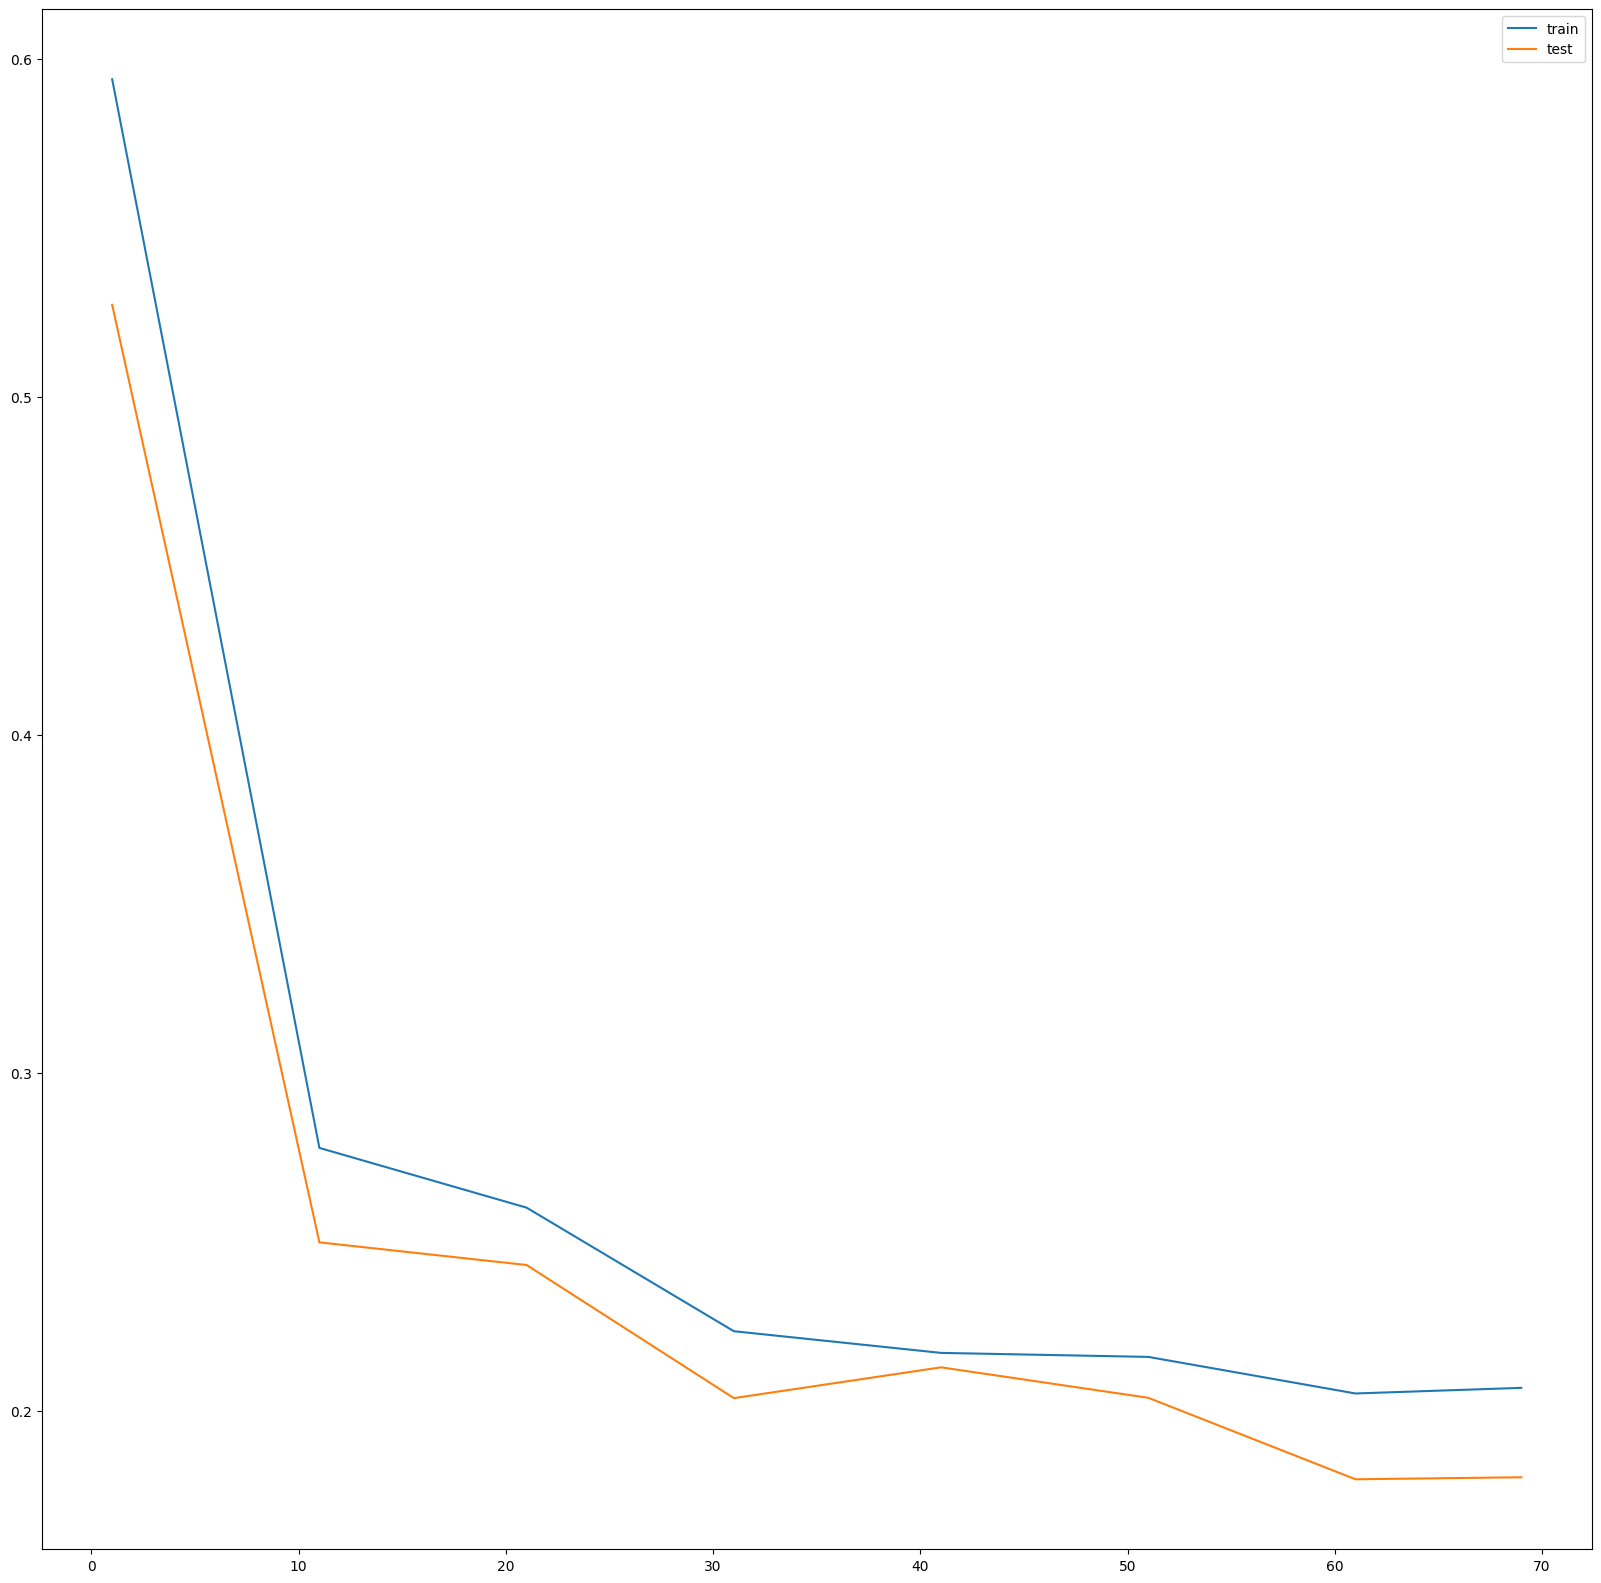

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

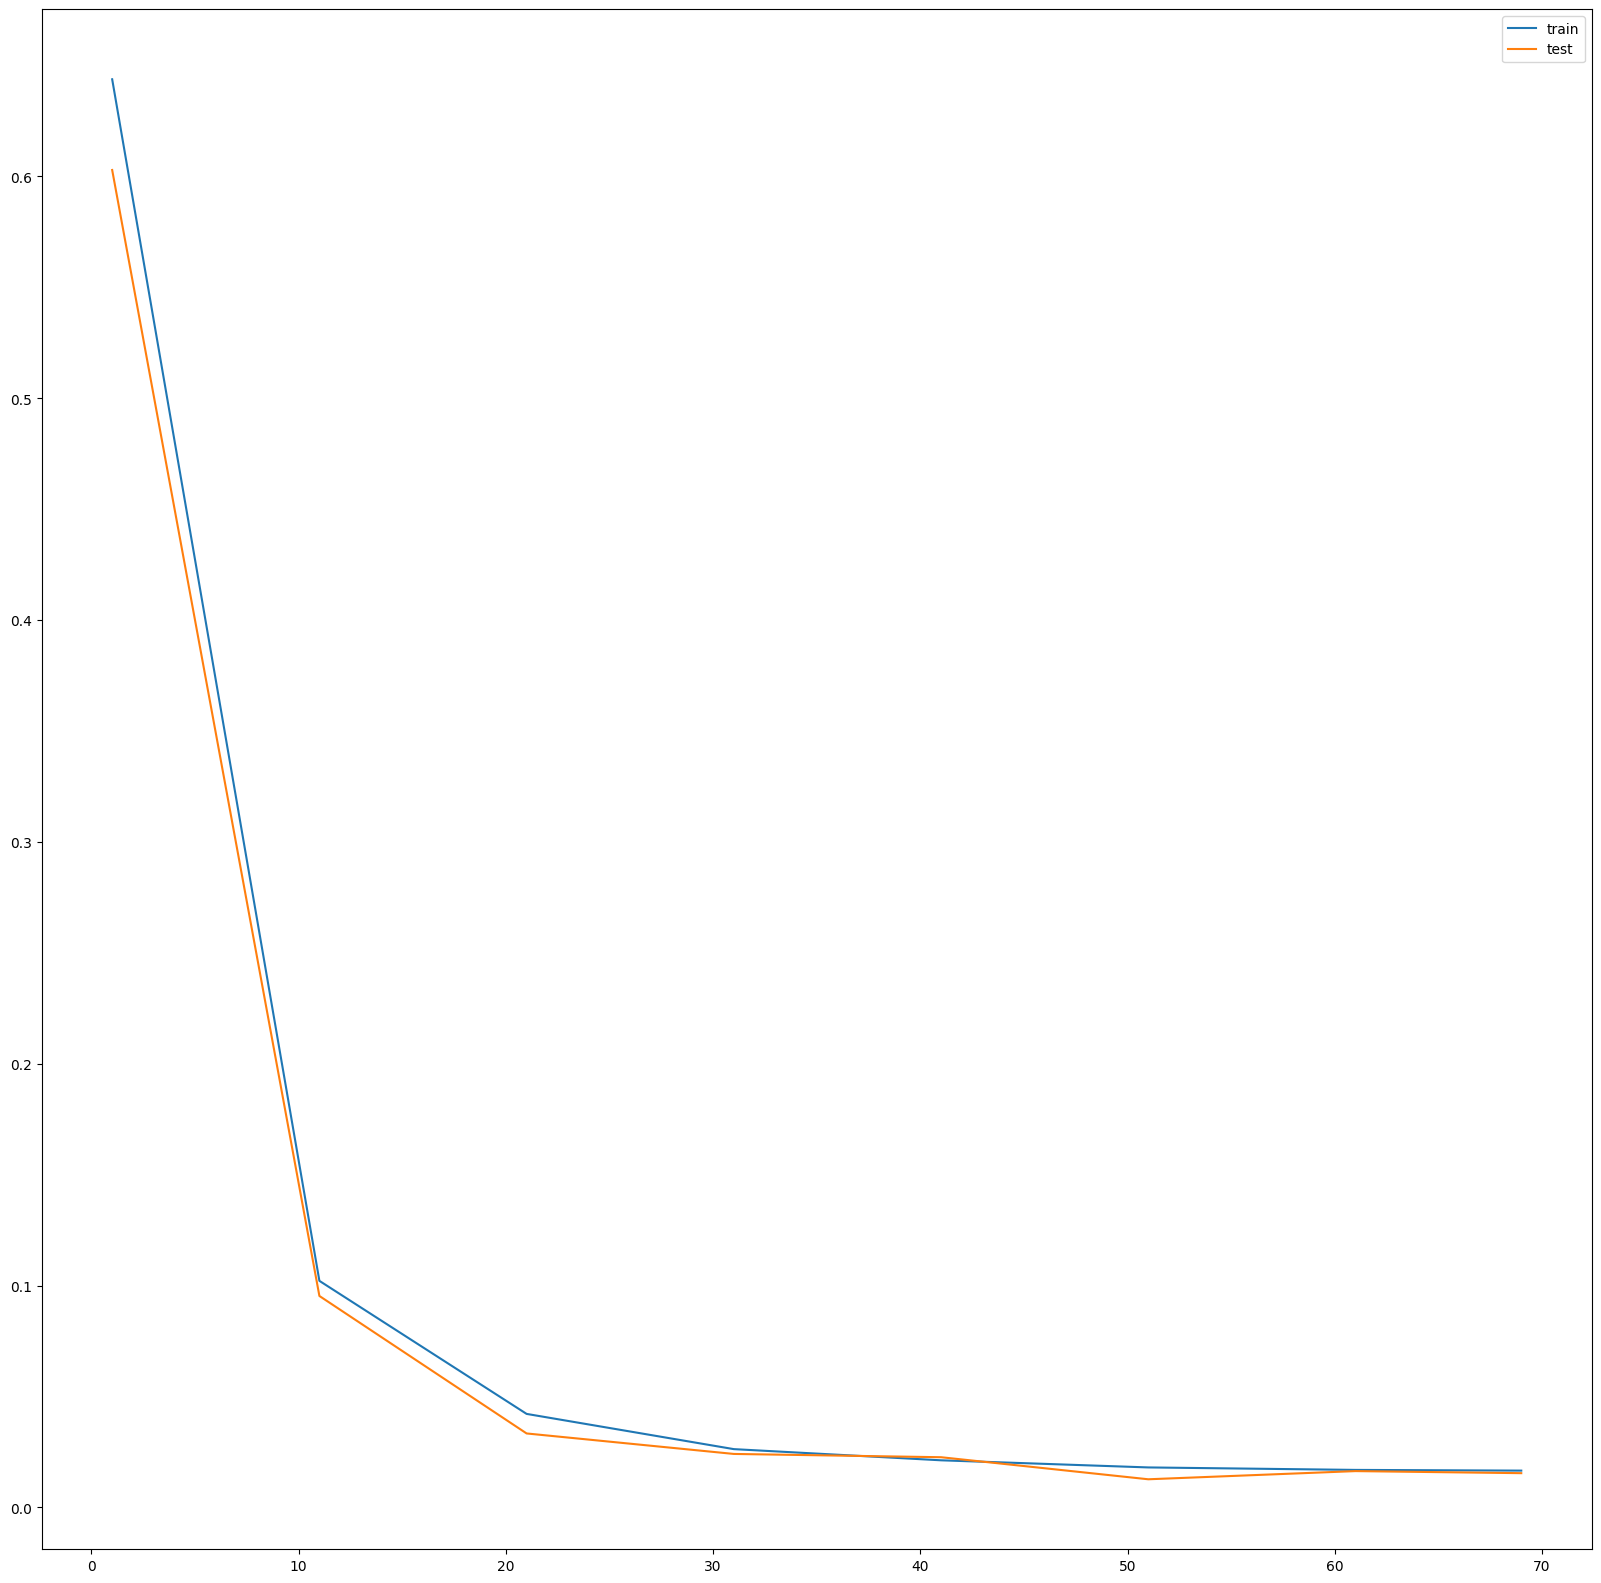

Error in callback <function _WandbInit._pause_backend at 0x7b0b74642170> (for post_run_cell):


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

BrokenPipeError: ignored

In [ ]:
start_with_wandb()

Error in callback <function _WandbInit._pause_backend at 0x7b0b74642170> (for post_run_cell):


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

BrokenPipeError: ignored

Error in callback <function _WandbInit._pause_backend at 0x7b0b74642170> (for post_run_cell):


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

BrokenPipeError: ignored